## Contents

[**Pre-EDA**](#pre-eda)

[**Answering the Questions**](#answering-the-questions)

*   [**Analysis at the "macro" level**](#analysis-at-the-macro-level)

    1.   [Which publisher has released the most games on Steam?](#which-publisher-has-released-the-most-games-on-steam)
        
    2.   [What are the best-rated games?](#what-are-the-best-rated-games)
        
    3.   [Are there years with more releases? Were there more or fewer game releases during Covid, for example?](#are-there-years-with-more-releases-were-there-more-or-fewer-game-releases-during-covid-for-example)
        
    4.   [How are prices distributed? Are there many games with a discount?](#how-are-prices-distributed-are-there-many-games-with-a-discount)
        
    5.   [What are the most represented languages?](#what-are-the-most-represented-languages)
        
    6.   [Are there many games prohibited for children under 16/18?](#are-there-many-games-prohibited-for-children-under-1618)
        

*   [**Genres analysis**](#genres-analysis)

    7.   [What are the most represented genres?](#what-are-the-most-represented-genres)
        
    8.   [Are there any genres that have a better positive/negative review ratio?](#are-there-any-genres-that-have-a-better-positivenegative-review-ratio)
        
    9.   [Do some publishers have favorite genres?](#do-some-publishers-have-favorite-genres)
        
    10.   [What are the most lucrative genres?](#what-are-the-most-lucrative-genres)
        

*   [**Platform analysis**]()

    11.   [Are most games available on Windows/Mac/Linux?](#are-most-games-available-on-windowsmaclinux)
        
    12.   [Do certain genres tend to be preferentially available on certain platforms?](#do-certain-genres-tend-to-be-preferentially-available-on-certain-platforms)

# Pre-EDA

A brief overview of the exploration I did before starting to answer the questions.

In [0]:
data_df = spark.read.json("s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json")
display(data_df)

In [0]:
data_df.count()

55691

In [0]:
data_df.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- appid: long (nullable = true)
 |    |-- categories: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ccu: long (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- discount: string (nullable = true)
 |    |-- genre: string (nullable = true)
 |    |-- header_image: string (nullable = true)
 |    |-- initialprice: string (nullable = true)
 |    |-- languages: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- negative: long (nullable = true)
 |    |-- owners: string (nullable = true)
 |    |-- platforms: struct (nullable = true)
 |    |    |-- linux: boolean (nullable = true)
 |    |    |-- mac: boolean (nullable = true)
 |    |    |-- windows: boolean (nullable = true)
 |    |-- positive: long (nullable = true)
 |    |-- price: string (nullable = true)
 |    |-- publisher: string (nullable = true)
 |    |-- release_date: string (nullable = true)
 |    |-

In [0]:
from pyspark.sql import functions as F

data_df_flattened = data_df.withColumn("appid", F.col("data.appid")) \
                           .withColumn("categories", F.col("data.categories")) \
                           .withColumn("genre", F.col("data.genre")) \
                           .withColumn("initialprice", F.col("data.initialprice")) \
                           .withColumn("languages", F.col("data.languages")) \
                           .withColumn("name", F.col("data.name")) \
                           .withColumn("negative_reviews", F.col("data.negative")) \
                           .withColumn("positive_reviews", F.col("data.positive")) \
                           .withColumn("price", F.col("data.price")) \
                           .withColumn("release_date", F.col("data.release_date")) \
                           .withColumn("owners", F.col("data.owners")) \
                           .withColumn("platforms", F.col("data.platforms")) \
                           .withColumn("publisher", F.col("data.publisher")) \
                           .withColumn("required_age", F.col("data.required_age")) \
                           .withColumn("tags", F.col("data.tags")) \
                           .withColumn("type", F.col("data.type")) \
                           .drop("data")

data_df_flattened.display()

In [0]:
data_df_flattened.filter(F.col("id") != F.col("appid")).count()

0

In [0]:
data_df_flattened = data_df_flattened.drop("id")

get_true_list = F.udf(lambda d: [key for key, value in d.asDict().items() if value])
data_df_flattened = data_df_flattened.withColumn("platforms", get_true_list(F.col("platforms")))\
                                     .withColumn("tags", get_true_list(F.col("tags")))

data_df_flattened.select(["platforms", "tags"]).display()

In [0]:
data_df_flattened = data_df_flattened.dropDuplicates()

for col in data_df_flattened:
    print(col.name())
    print(data_df_flattened.filter(col.isNull()).count())
    print()

Column<'appid AS '>
0

Column<'categories AS '>
0

Column<'genre AS '>
0

Column<'initialprice AS '>
0

Column<'languages AS '>
0

Column<'name AS '>
0

Column<'negative_reviews AS '>
0

Column<'positive_reviews AS '>
0

Column<'price AS '>
0

Column<'release_date AS '>
0

Column<'owners AS '>
0

Column<'platforms AS '>
0

Column<'publisher AS '>
0

Column<'required_age AS '>
0

Column<'tags AS '>
0

Column<'type AS '>
0



In [0]:
data_df_flattened.select(F.col("type")).distinct().display()

type
hardware
game


In [0]:
data_df_flattened.filter(F.col("type") == "hardware").display()

appid,categories,genre,initialprice,languages,name,negative_reviews,positive_reviews,price,release_date,owners,platforms,publisher,required_age,tags,type
353380,"List(Full controller support, Remote Play Together)",,0,,Steam Link,1771,5803,0,2015/11/10,"500,000 .. 1,000,000","[linux, mac, windows]",Anima Locus,0,"[Comedy, Competitive, Epic, Great Soundtrack, Hentai, Local Multiplayer, Post-apocalyptic, PvP, RPG, Shooter, Software, Steam Machine, Survival, Survival Horror]",hardware


In [0]:
data_df_flattened = data_df_flattened.filter(F.col("type") != "hardware")

In [0]:
data_df_flattened.select(F.col("type")).distinct().display()

type
game


In [ ]:
data_df_flattened.filter(F.col("publisher") == "").display()

# I decided to leave these rows in because they are fine otherwise, and because they don't prevent me from performing the analyses I need

appid,categories,genre,initialprice,languages,name,negative_reviews,positive_reviews,price,release_date,owners,platforms,publisher,required_age,tags,type
1003690,"List(Multi-player, Single-player, Shared/Split Screen, Full controller support, Shared/Split Screen PvP, Remote Play Together, PvP)","Casual, Indie, Strategy",999,English,CrossTrix,0,1,999,2019/01/3,"0 .. 20,000",[windows],,0,"[Casual, Indie, Puzzle, Strategy]",game
1023410,List(Single-player),Adventure,999,"French, English",3 GEEKS - La version Gauloise pour les francophones !,3,13,999,2019/02/22,"0 .. 20,000",[windows],,0,"[2D, Adventure, Cartoony, Cute, Dark Comedy, Funny, Hand-drawn, Indie, Mouse only, Point & Click, Post-apocalyptic, Puzzle, Relaxing]",game
1096570,"List(Single-player, Steam Achievements, Steam Cloud, Full controller support)",Adventure,2999,"English, French, German, Spanish - Spain",SONG OF HORROR COMPLETE EDITION,215,992,1799,2019/10/31,"100,000 .. 200,000",[windows],,0,"[Action, Action-Adventure, Adventure, Atmospheric, Choices Matter, Cinematic, Dark, Exploration, Horror, Investigation, Lovecraftian, Mature, Psychological Horror, Replay Value, Singleplayer, Story Rich, Supernatural, Survival, Survival Horror, Third Person]",game
111300,"List(Single-player, Partial Controller Support, Steam Achievements, Steam Cloud, Steam Leaderboards)","Action, Racing, Sports",999,"English, Russian",Smash Cars,13,29,999,2011/10/18,"0 .. 20,000",[windows],,0,"[Action, Racing, Sports]",game
1117470,List(Single-player),"Casual, Indie",999,English,Seven Wonders of St. Clementine,8,1,99,2020/10/30,"0 .. 20,000","[linux, mac, windows]",,0,"[2D, Anime, Casual, Choices Matter, Dark, Foreign, Gore, Hand-drawn, Horror, Indie, Interactive Fiction, Mature, Mystery, Nonlinear, Psychological Horror, Singleplayer, Story Rich, Supernatural, Violent, Visual Novel]",game
1167350,List(Single-player),"Action, Adventure, Casual, Indie",899,English,Skyous,2,0,899,2019/10/15,"0 .. 20,000",[windows],,0,"[Action, Adventure, Casual, Indie]",game
1248550,"List(Single-player, Steam Achievements, Full controller support)","Action, Indie, Early Access",699,"English, Japanese, Portuguese - Brazil, French, Italian, German, Spanish - Spain, Korean, Thai, Portuguese - Portugal",Breaking Gates,12,37,244,2020/11/17,"0 .. 20,000",[windows],,0,"[2D, 2D Platformer, Action, Anime, Colorful, Combat, Cute, Early Access, Exploration, Fantasy, Hack and Slash, Indie, Metroidvania, Platformer, Side Scroller, Singleplayer]",game
1268150,"List(Multi-player, Single-player, Partial Controller Support, Online PvP, Remote Play Together, PvP)","Action, Adventure, Casual, Indie, Massively Multiplayer, Simulation, Strategy",199,English,Low Poly Forces,7,28,199,2020/06/22,"0 .. 20,000",[windows],,0,"[Action, Adventure, Casual, Free to Play, Indie, Massively Multiplayer, Simulation, Sports, Strategy]",game
1281400,"List(Multi-player, Single-player, Co-op, Stats, Includes level editor, Steam Achievements, Steam Cloud, Shared/Split Screen, Steam Leaderboards, Full controller support, Steam Workshop, Shared/Split Screen Co-op, Remote Play Together)","Action, Casual, Indie, Early Access",1499,"English, Simplified Chinese",Good Knight,1,76,1499,2021/09/17,"20,000 .. 50,000","[linux, windows]",,0,"[Arcade, Bullet Hell, Casual, Co-op, Dark, Dark Comedy, Dark Fantasy, Dark Humor, Difficult, Early Access, Fast-Paced, Funny, Gothic, Mythology, Psychedelic, Psychological, Rhythm, Score Attack, Stylized, Top-Down Shooter]",game
12900,"List(Single-player, Co-op, Steam Achievements, Full controller support)",Indie,999,"English, Russian",AudioSurf,437,10082,999,2008/02/15,"1,000,000 .. 2,000,000",[windows],,0,"[Addictive, Arcade, Casual, Co-op, Colorful, Fast-Paced, Great Soundtrack, Indie, Local Co-Op, Local Multiplayer, Music, Music-Based Procedural Generation, Procedural Generation, Puzzle, Racing, Relaxing, Replay Value, Rhythm, Score Attack, Singleplayer]",game


In [ ]:
data_df_flattened.filter(F.col("release_date") == "").display()

appid,categories,genre,initialprice,languages,name,negative_reviews,positive_reviews,price,release_date,owners,platforms,publisher,required_age,tags,type
102500,"List(Single-player, Partial Controller Support, Steam Achievements, Steam Cloud, Remote Play on Tablet)","Action, RPG",0,"English, French, German, Italian, Spanish - Spain",Kingdoms of Amalur: Reckoning,1492,11184,0,,"2,000,000 .. 5,000,000",[windows],"38 Studios, Electronic Arts",15,"[Action, Action RPG, Adventure, Atmospheric, Character Customization, Controller, Crafting, Exploration, Fantasy, Female Protagonist, Great Soundtrack, Hack and Slash, Loot, Magic, Open World, RPG, Sandbox, Singleplayer, Story Rich, Third Person]",game
1075950,"List(Multi-player, Single-player, Full controller support, Online PvP, PvP)","Action, Strategy",0,English,Disintegration Technical Beta,342,1144,0,,"0 .. 20,000",[windows],Private Division,0,"[Action, FPS, RTS, Strategy]",game
1173590,"List(Multi-player, Single-player, Co-op, Shared/Split Screen, Shared/Split Screen PvP, Shared/Split Screen Co-op, Remote Play Together, PvP)","Free to Play, Indie, Strategy",0,English,Dominus Galaxia: KS Edition,31,162,0,,"0 .. 20,000","[linux, mac, windows]",StarChart-Interactive,0,"[4X, Free to Play, Indie, Space, Strategy]",game
1269260,"List(Multi-player, Single-player, Online PvP, PvP)",Strategy,0,"English, French, Italian, German, Spanish - Spain, Japanese, Korean, Polish, Portuguese - Brazil, Russian, Simplified Chinese, Spanish - Latin America, Thai, Traditional Chinese, Turkish",Artifact Foundry,306,379,0,,"0 .. 20,000","[linux, mac, windows]",Valve,0,"[Board Game, Card Game, Free to Play, Hand-drawn, Multiplayer, Puzzle, Singleplayer, Strategy, Top-Down]",game
1321650,"List(Single-player, Steam Achievements, Full controller support)","Action, Adventure, Indie",0,English,Rocket Ghost Aidan 2,0,14,0,,"0 .. 20,000",[windows],Bobby Schwind,0,"[2D, 2D Platformer, Action, Action-Adventure, Adventure, Arcade, Cartoony, Character Customization, Colorful, Cute, Exploration, Indie, Platformer, Precision Platformer, Retro, Singleplayer]",game
1402480,"List(Multi-player, Online PvP, PvP)","Action, Adventure",0,"English, Japanese, Simplified Chinese, Traditional Chinese, Korean",NARAKA: BLADEPOINT / 永劫無間 - Test Server,22,100,0,,"0 .. 20,000",[windows],24 Entertainment,0,"[Action, Adventure, Co-op, Gore, Online Co-Op, PvP, Violent]",game
15540,"List(Single-player, Steam Achievements, Steam Trading Cards)","Action, Indie, Early Access",0,English,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),383,151,0,,"50,000 .. 100,000",[windows],"Dejobaan Games, LLC",0,"[Action, Early Access, Indie, Music, Music-Based Procedural Generation, Procedural Generation, Rhythm, Singleplayer]",game
201830,"List(Single-player, Partial Controller Support, Steam Achievements)",Adventure,0,"English, French, German",Jurassic Park: The Game,638,1313,0,,"200,000 .. 500,000","[mac, windows]",Telltale Games,0,"[Action, Adventure, Atmospheric, Choices Matter, Dinosaurs, Episodic, Female Protagonist, Horror, Movie, Point & Click, Quick-Time Events, Sci-fi, Singleplayer, Story Rich, Survival]",game
202170,"List(Single-player, Steam Achievements, Full controller support, Steam Trading Cards)","Action, Adventure",0,"English, French, German, Italian, Spanish - Spain, Russian, Polish",Sleeping Dogs,922,15808,0,,"2,000,000 .. 5,000,000",[windows],Square Enix,15,"[Action, Adventure, Atmospheric, Automobile Sim, Crime, Driving, Fighting, Great Soundtrack, Martial Arts, Multiplayer, Open World, Parkour, RPG, Sandbox, Shooter, Singleplayer, Story Rich, Third Person, Third-Person Shooter, Violent]",game
203680,"List(Multi-player, Single-player, Co-op, Partial Controller Support, Steam Achievements, Steam Cloud, Shared/Split Screen, Remote Play Together)",Racing,0,"English, German, French, Italian, Spanish - Spain, Japanese, Polish, Portuguese - Brazil",F1 RACE STARS,395,1439,0,,"500,000 .. 1,000,000",[windows],"Codemasters, Electronic 

In [0]:
data_df_flattened.select(F.col("required_age")).distinct().display()

required_age
0
14
21+
9
16
35
6
12
7
7+


# Answering the Questions

In [0]:
from pyspark.sql.types import ArrayType, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np

In [0]:
# All the edits I made during the EDA phase and that I want to keep

get_true_list = F.udf(lambda d: [key for key, value in d.asDict().items() if value])

df = spark.read.json("s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json")\
    .withColumn("appid", F.col("data.appid")) \
    .withColumn("categories", F.col("data.categories")) \
    .withColumn("genre", F.col("data.genre")) \
    .withColumn("initialprice", F.col("data.initialprice")) \
    .withColumn("languages", F.col("data.languages")) \
    .withColumn("name", F.col("data.name")) \
    .withColumn("negative_reviews", F.col("data.negative")) \
    .withColumn("positive_reviews", F.col("data.positive")) \
    .withColumn("price", F.col("data.price")) \
    .withColumn("release_date", F.col("data.release_date")) \
    .withColumn("owners", F.col("data.owners")) \
    .withColumn("publisher", F.col("data.publisher")) \
    .withColumn("required_age", F.regexp_substr("data.required_age",
                                                F.lit(r"\d{1,2}")).cast("long"))\
    .withColumn("type", F.col("data.type")).filter(F.col("type") != "hardware") \
    .withColumn("platforms", F.regexp_substr(get_true_list(F.col("data.platforms")),
                                             F.lit(r"[a-zA-Z]+")))\
    .withColumn("tags", get_true_list(F.col("data.tags")))\
    .drop("data", "id", "type")

In [0]:
def get_head_as_df(df_name):
    spark.createDataFrame(df_name.take(20)).display()

## Analysis at the "macro" level

### Which publisher has released the most games on Steam?

In [0]:
most_games_df = df.filter(F.col("publisher") != "")\
                  .groupBy(F.col("publisher"))\
                  .agg((F.count("appid")).alias("game_count"))\
                  .orderBy(F.desc("game_count"))
get_head_as_df(most_games_df)


publisher,game_count
Big Fish Games,422
8floor,202
SEGA,165
Strategy First,151
Square Enix,141
Choice of Games,140
HH-Games,132
Sekai Project,132
Ubisoft,127
Laush Studio,126


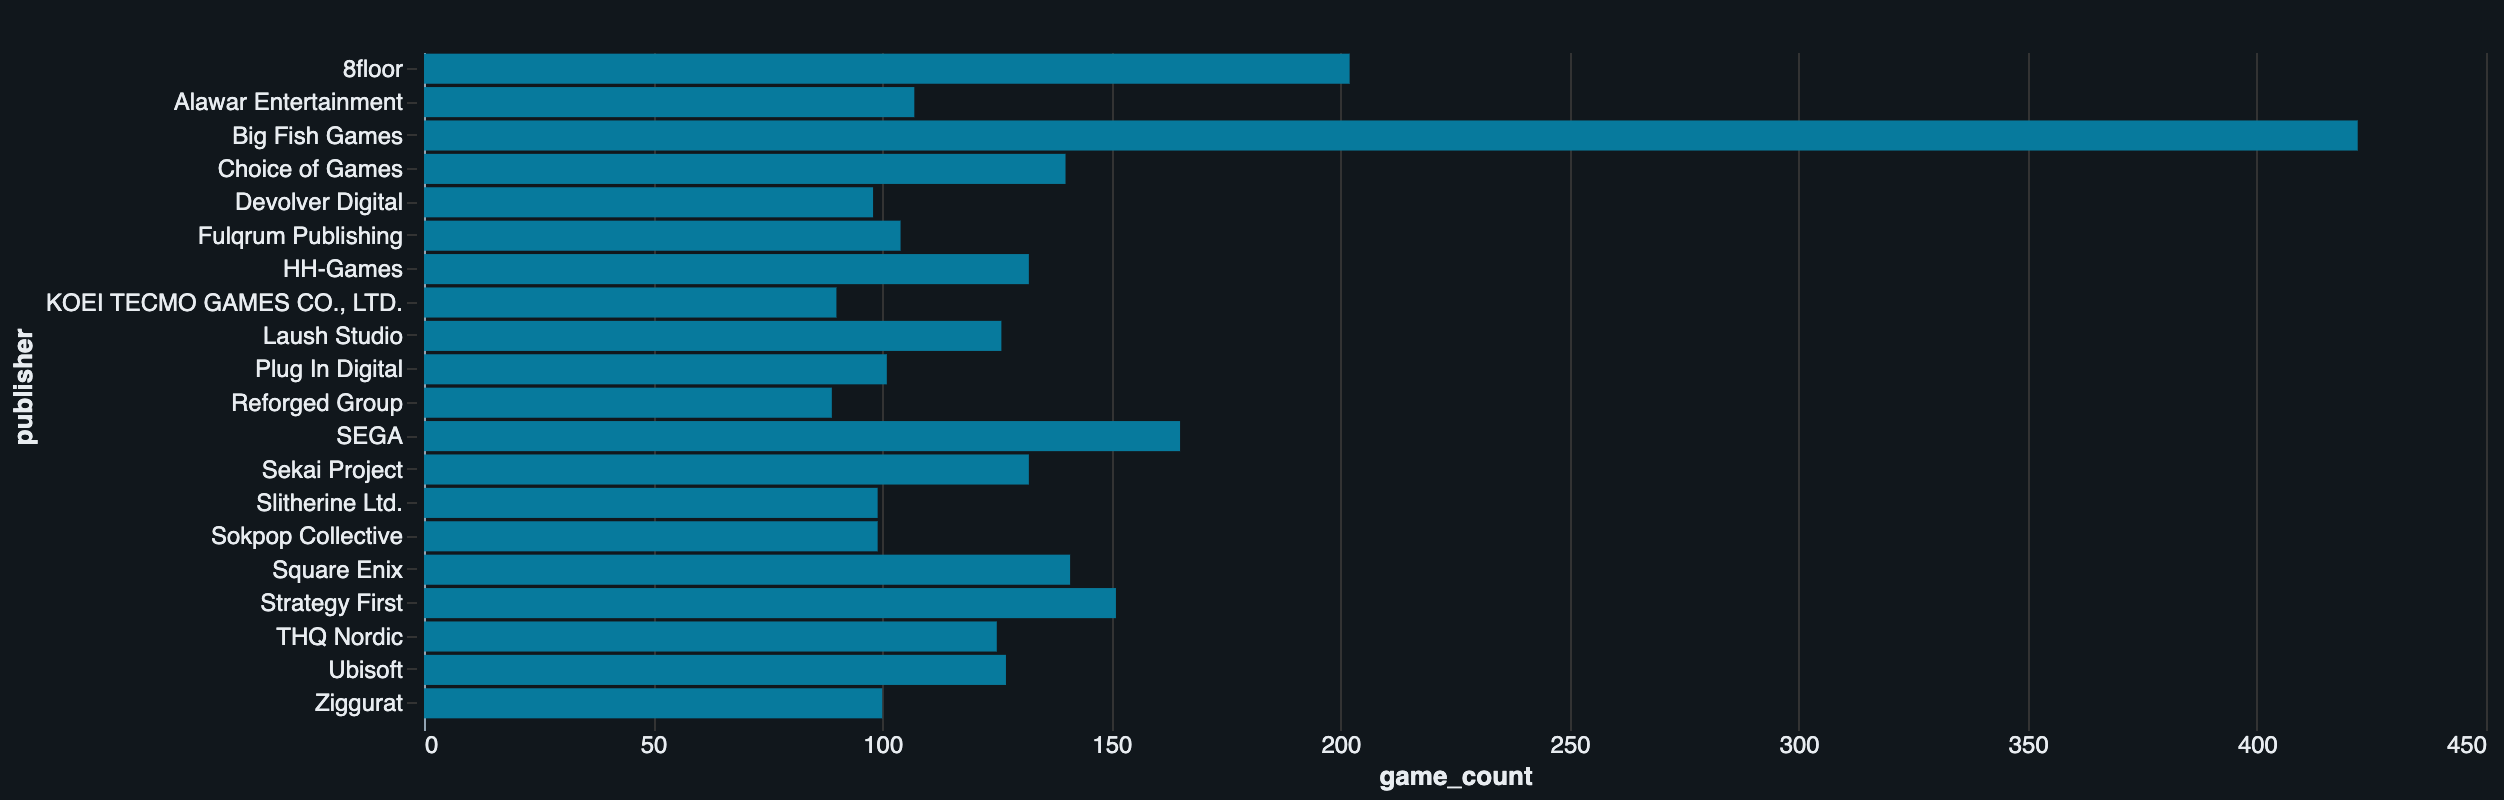

"Big Fish Games" has published the most games by far.

### What are the best-rated games?

In [0]:
best_rated_df = df.groupBy(F.col("appid"))\
                  .agg((F.string_agg_distinct("name")).alias("name"), # in case the same game appears with different names
                       (F.sum("positive_reviews") - F.sum("negative_reviews")).alias("net_rating"))\
                  .orderBy(F.desc("net_rating"))
get_head_as_df(best_rated_df)

appid,name,net_rating
730,Counter-Strike: Global Offensive,5156252
570,Dota 2,1216979
271590,Grand Theft Auto V,1015886
105600,Terraria,992331
4000,Garry's Mod,831242
359550,Tom Clancy's Rainbow Six Siege,799663
440,Team Fortress 2,788984
550,Left 4 Dead 2,627008
252490,Rust,620359
292030,The Witcher 3: Wild Hunt,607382


Databricks visualization. Run in Databricks to view.

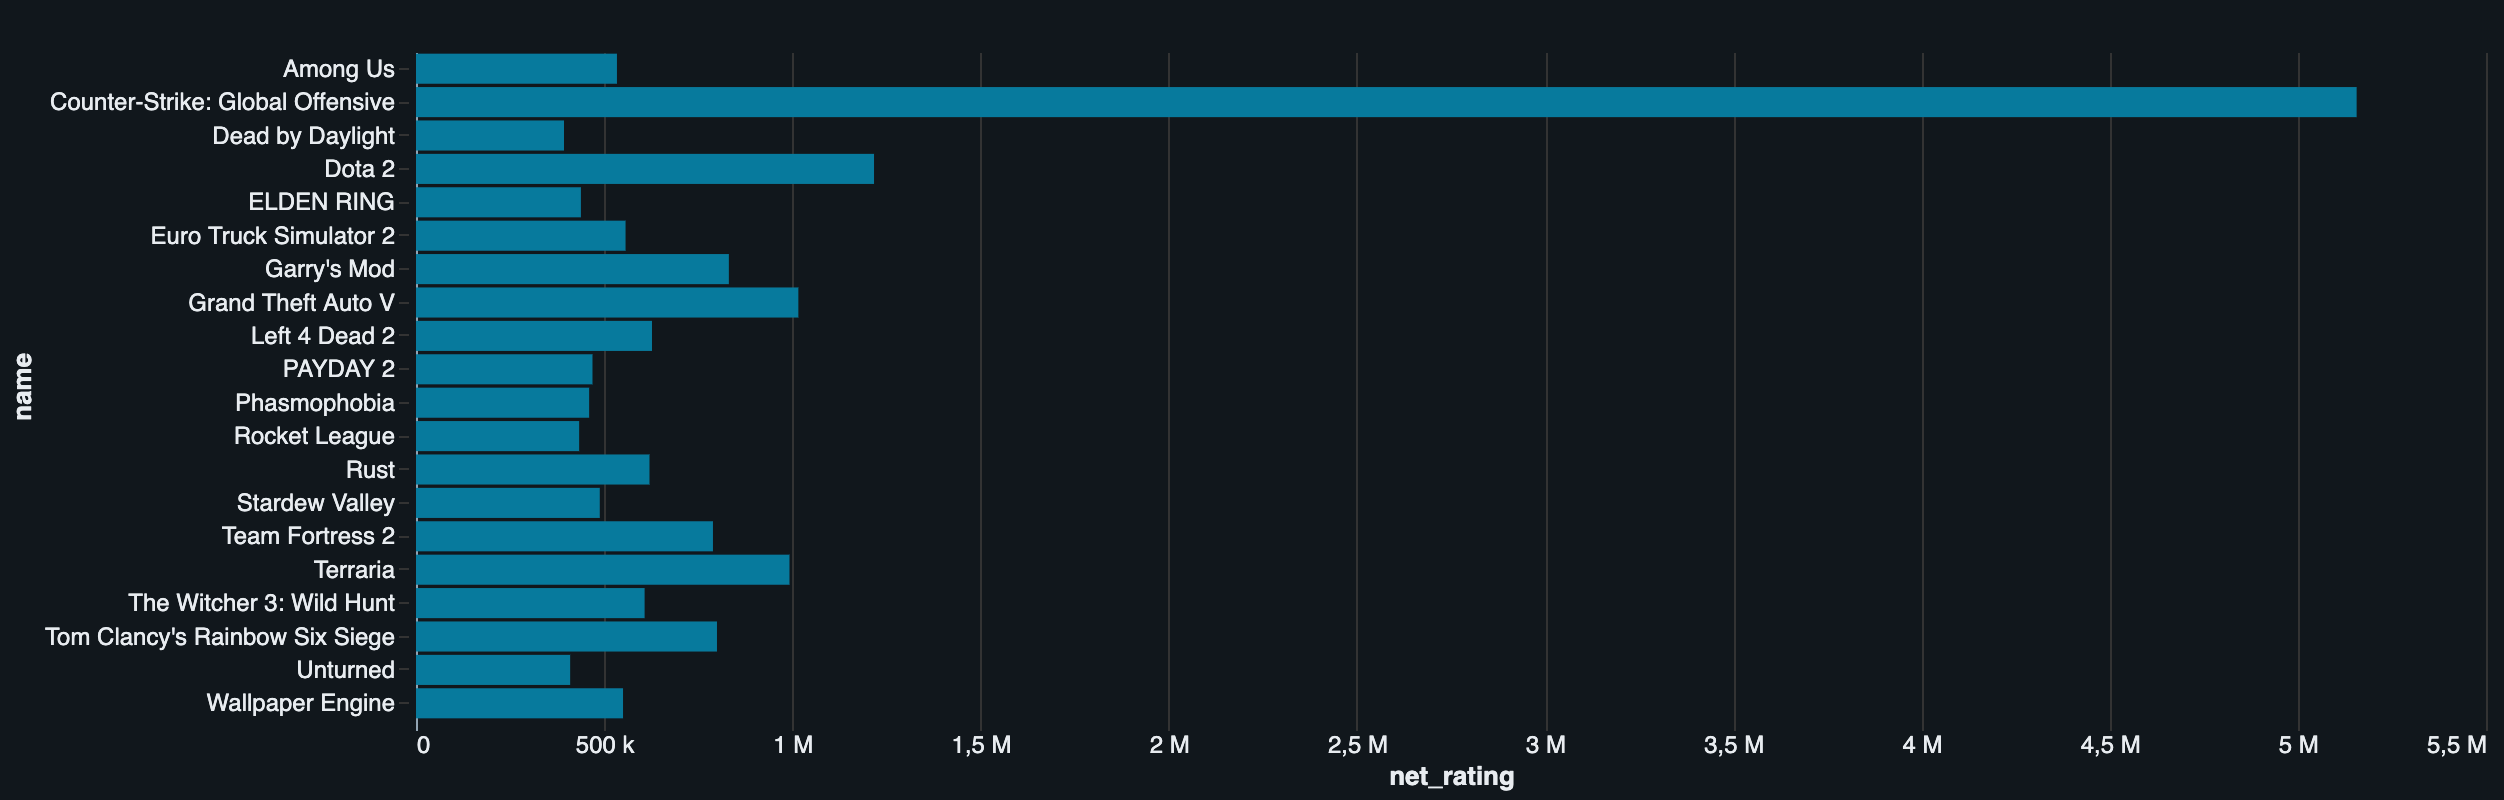

The top 10 best-rated games are:
- Counter-Strike: Global Offensive
- Dota 2
- Grand Theft Auto V
- Terraria
- Garry's Mod
- Tom Clancy's Rainbow Six Siege
- Team Fortress 2
- Left 4 Dead 2
- Rust
- The Witcher 3: Wild Hunt

### Are there years with more releases? Were there more or fewer game releases during Covid, for example?

In [0]:
# lazy solution

big_years_df = df.filter(F.col("release_date") != "")\
                 .withColumn("release_year", F.col("release_date")[0:4])\
                 .groupBy(F.col("release_year"))\
                 .agg((F.count("appid")).alias("release_count"))\
                 .orderBy(F.desc("release_count"))
big_years_df.display()

# I specified the 0 start position in the slice because pyspark doesn't understand `F.col("release_date")[:4]`

release_year,release_count
2021,8823
2020,8305
2018,7678
2022,7455
2019,6968
2017,6017
2016,4185
2015,2575
2014,1557
2013,471


In [0]:
# show-off solution

def fix_dates(date_str):
     match len(date_str):
          case 7:
               return date_str + "/01"
          case 9:
               return date_str[:8] + "0" + date_str[8]
          case 10:
               return date_str
          case _:
               raise Exception(f"The string was {len(date_str)} characters long.")

fix_dates = F.udf(fix_dates)

big_years_df = df.filter(F.col("release_date") != "")\
                 .withColumn("release_year",
                             F.year(
                                  F.to_date(
                                       fix_dates(F.col("release_date")),
                                       "yyyy/MM/dd")))\
                 .groupBy(F.col("release_year"))\
                 .agg((F.count("appid")).alias("release_count"))\
                 .orderBy(F.desc("release_count"))
get_head_as_df(big_years_df)

release_year,release_count
2021,8823
2020,8305
2018,7678
2022,7455
2019,6968
2017,6017
2016,4185
2015,2575
2014,1557
2013,471


Databricks visualization. Run in Databricks to view.

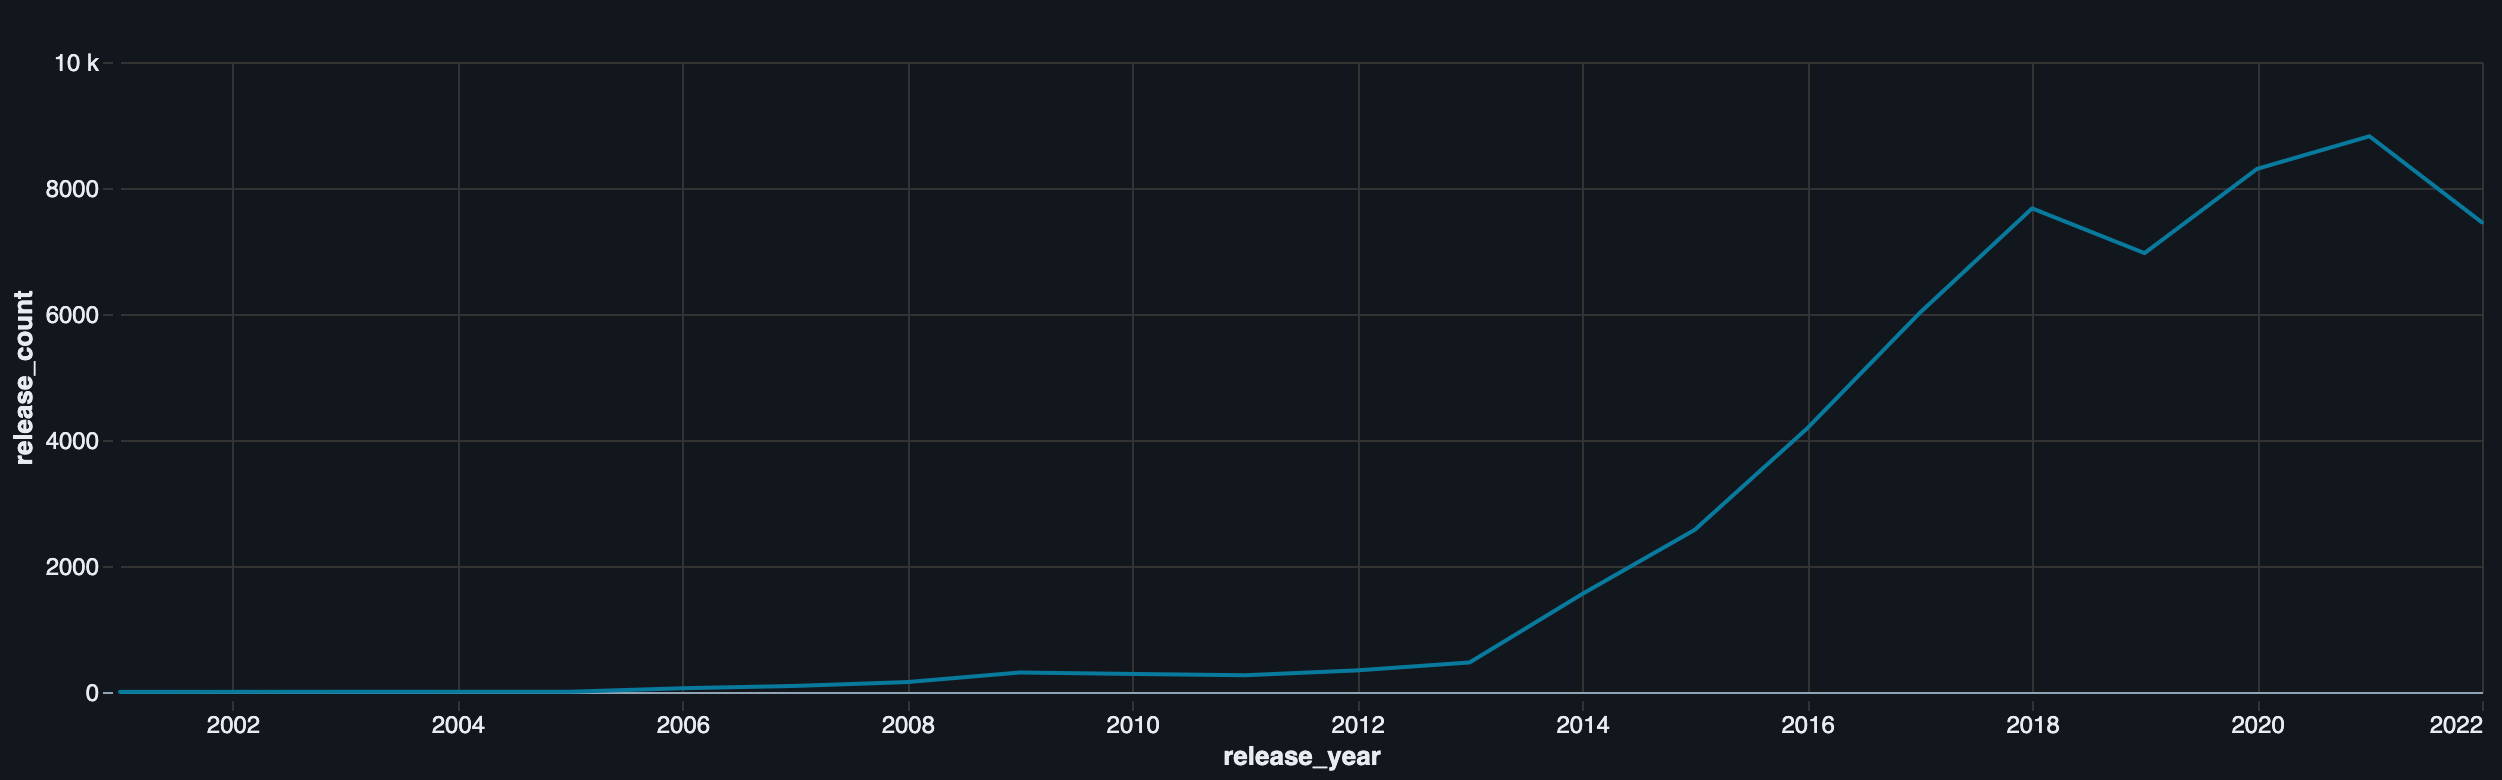

Until 2013, publishers were still shy about publishing on Steam. From then onwards, yearly releases skyrocket.\
There is a little dip in 2019, but SARS-CoV-2 came to the rescue with the highest peak in the data in 2021.\
The data stops in 2022, still in the throws of the Covid pandemic, and release rates had come down to just about where they were before the 2019 dip.

### How are prices distributed? Are there many games with a discount?

In [0]:
has_discount_rows = df.withColumn("has_discount", F.col("price") < F.col("initialprice"))\
                      .select(F.col("has_discount"))\
                      .collect()
has_discount_binary = [1 if row_obj["has_discount"] else 0
                       for row_obj in has_discount_rows]

percentage_discounted = sum(has_discount_binary) / len(has_discount_binary) * 100
print(f"{percentage_discounted:.2f}% of games in the data have a discount")

4.52% of games in the data have a discount


In [0]:
price_distrib_df = df.filter(F.col("price") != "")\
                     .groupBy(F.col("price").cast("long"))\
                     .agg((F.count("appid")).alias("game_count_for_price"))\
                     .orderBy(F.asc("price"))
price_distrib_df.display()

price,game_count_for_price
0,7779
28,20
29,11
30,2
31,6
37,19
38,7
39,7
41,10
44,1


Databricks visualization. Run in Databricks to view.

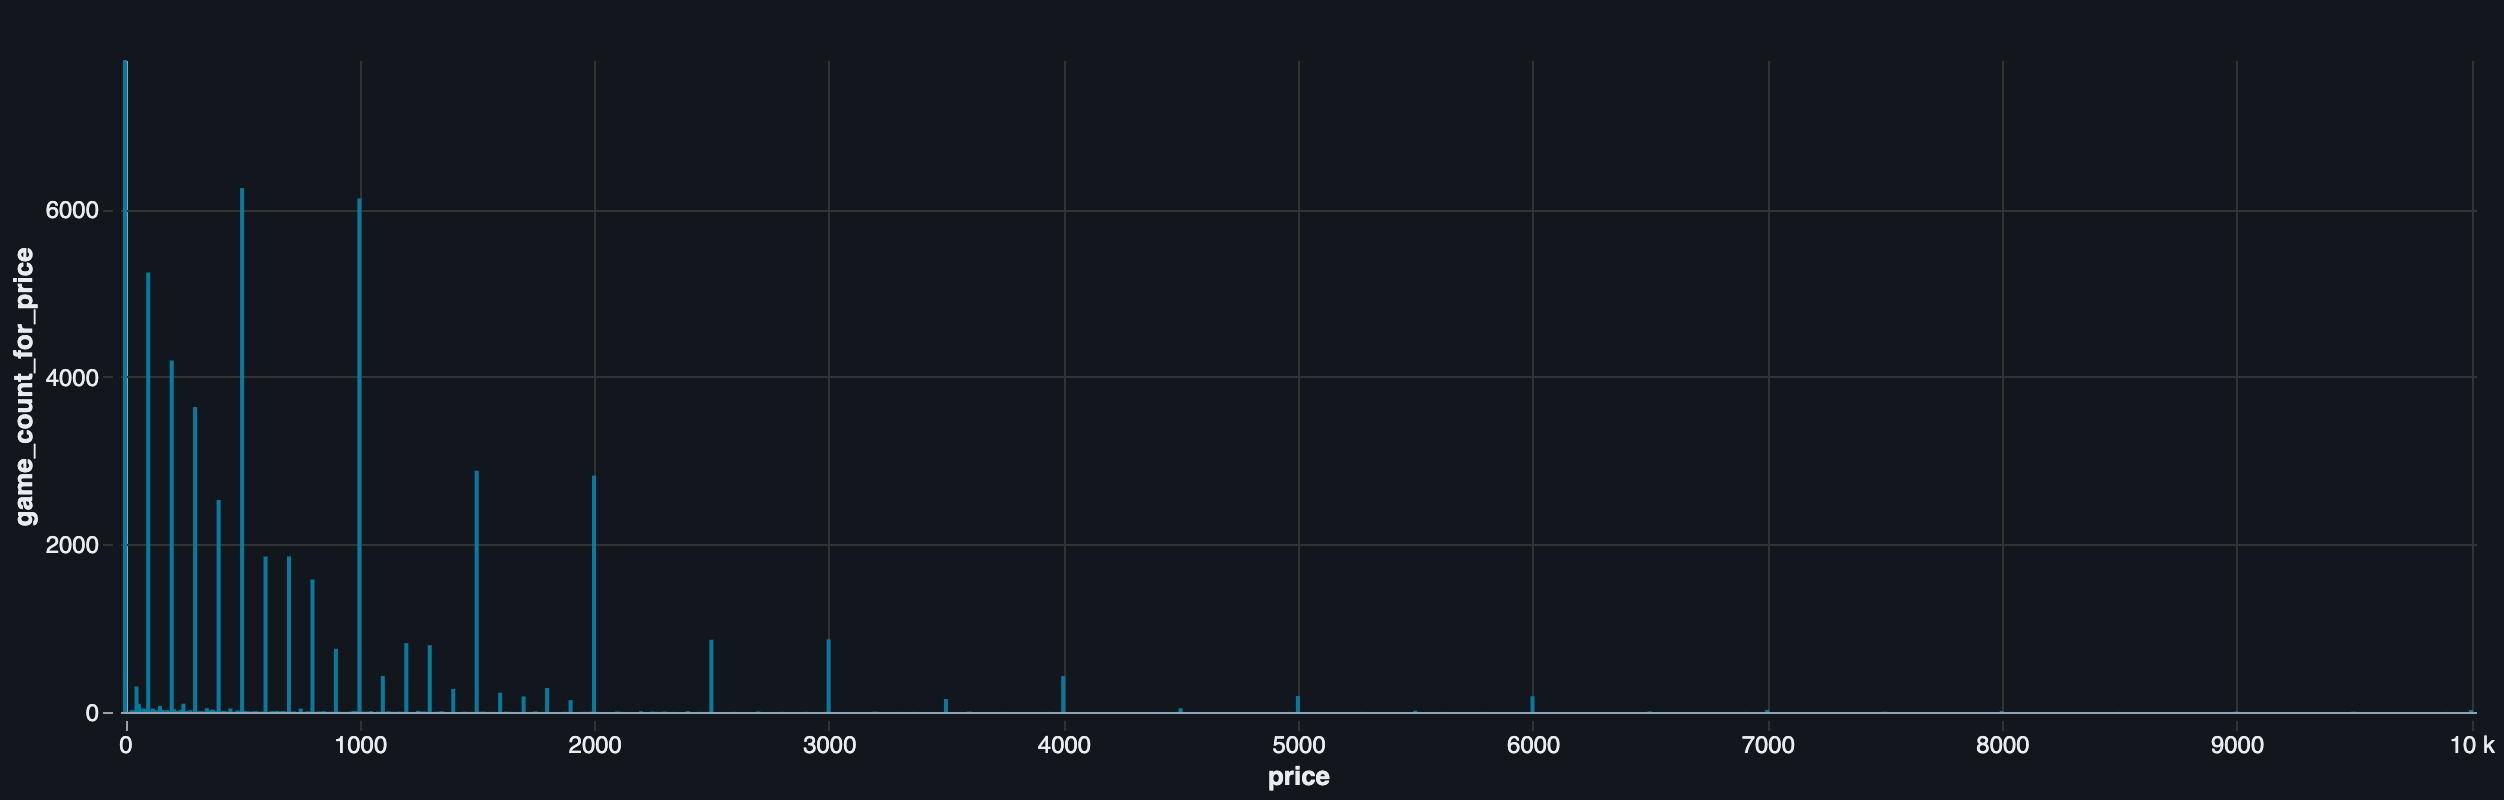

- What the currency is is unclear, but it doesn't seem to be either € or £. It could be ¥ (Japanese Yen).
- Assuming ¥, many games are free to download (presumably with in-game purchases) and most have a price below ¥1,000 (~€5.75).
- There are spikes in the distribution of prices at every $500n-1$. It makes sense that there would be many games with these prices, as 1,000 is a nice, round power of ten, because 500 is a nice half of that, and because it is very common to lower a price a tiny bit to make an item look cheaper.
- There are also a few outliers. The bar plot above is filtered to only display prices up to ¥10,000, but there are a few outliers in the data pricing above that and up to ¥100,000.

### What are the most represented languages?

In [0]:
get_lang_list = F.udf(lambda langs: [lang.strip() for lang in langs.split(",")],
                      ArrayType(StringType()))

languages_df = df.filter(F.col("languages") != "")\
                 .withColumn("languages",
                             F.explode(
                                 get_lang_list(
                                     F.col("languages"))))\
                 .groupBy(F.col("languages"))\
                 .agg(F.count("appid").alias("num_occurrences"))\
                 .orderBy(F.desc("num_occurrences"))
get_head_as_df(languages_df) # some rows are malformed, but it doesn't affect the results one bit

languages,num_occurrences
English,55116
German,14019
French,13426
Russian,12922
Simplified Chinese,12782
Spanish - Spain,12233
Japanese,10368
Italian,9304
Portuguese - Brazil,6750
Korean,6600


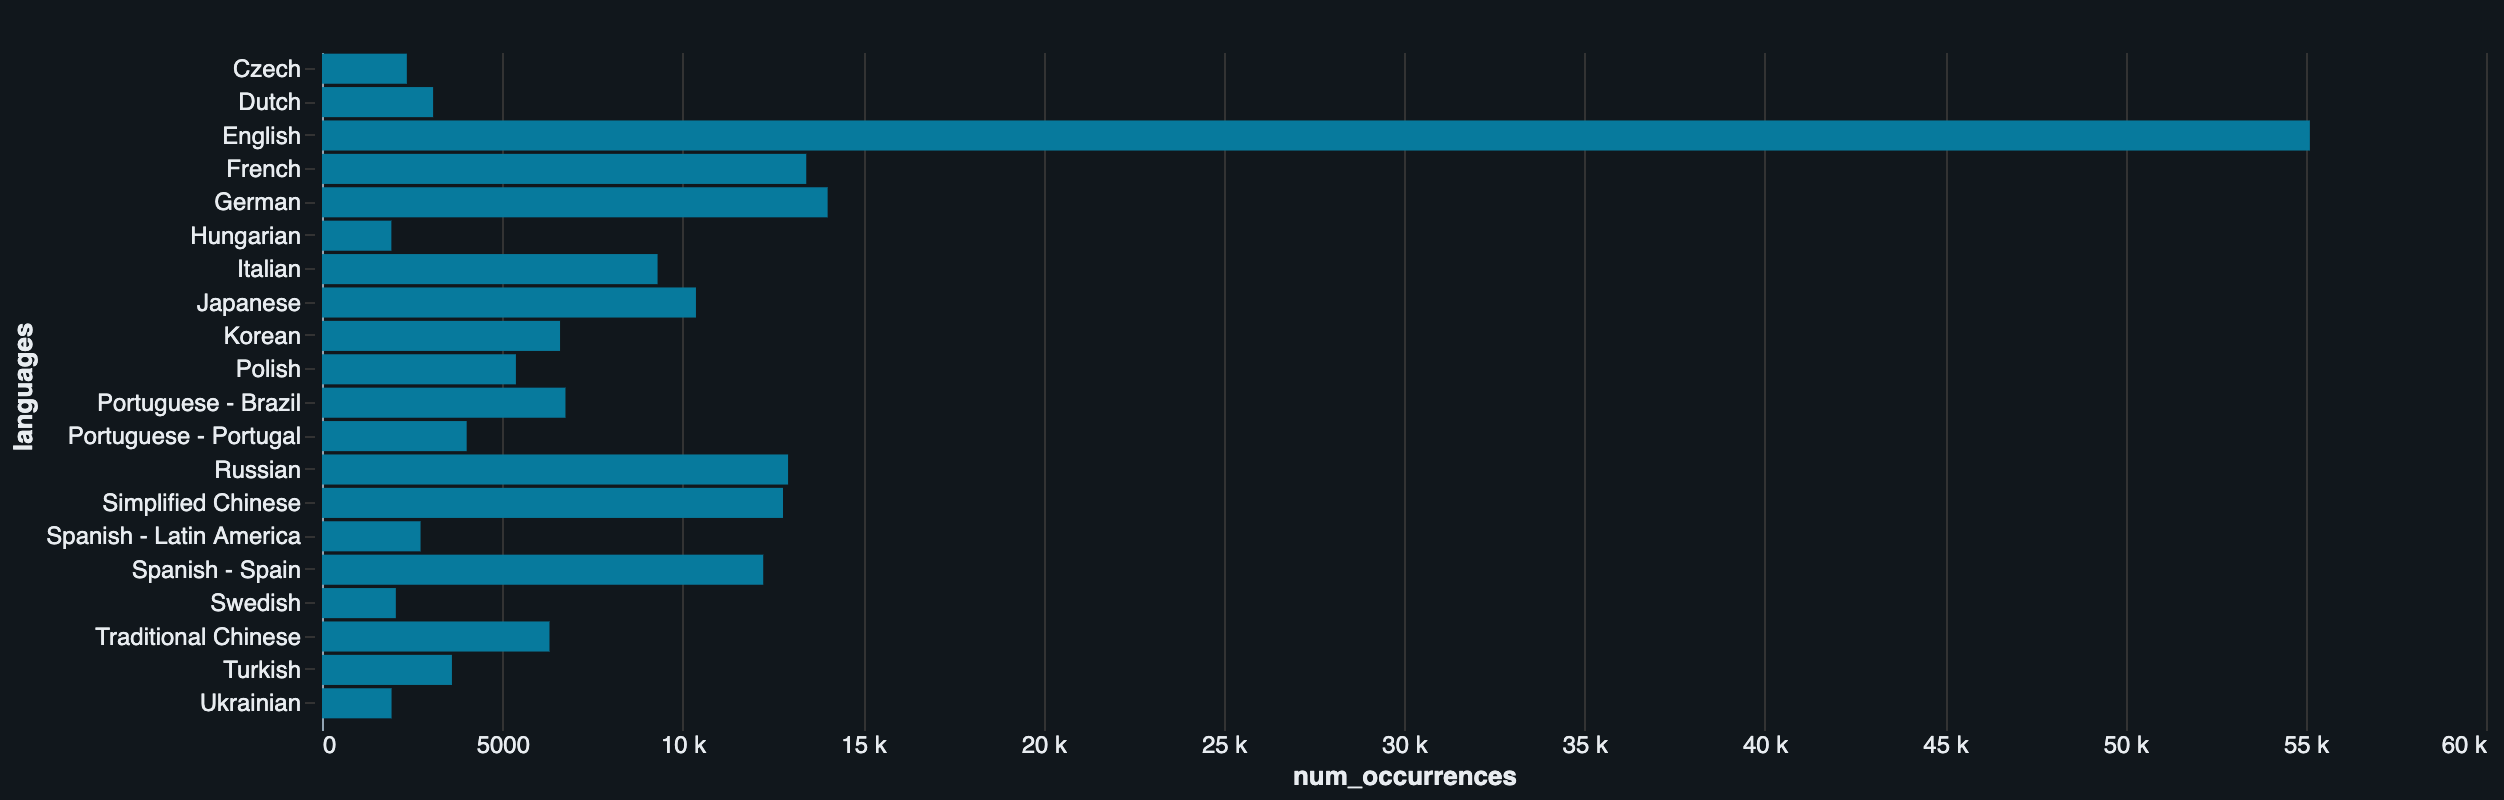

### Are there many games prohibited for children under 16/18?

In [0]:
forbidden_age_df = df.withColumn("forbidden_under_16", 16 <= F.col("required_age"))\
                     .withColumn("forbidden_under_18", 18 <= F.col("required_age"))

is_forbidden_under_16_binary = [1 if row_obj["forbidden_under_16"] else 0
                                for row_obj in forbidden_age_df.select(F.col("forbidden_under_16"))\
                                                               .collect()]
percentage_forbidden_under_16 = sum(is_forbidden_under_16_binary)\
                                / len(is_forbidden_under_16_binary)\
                                * 100

is_forbidden_under_18_binary = [1 if row_obj["forbidden_under_18"] else 0
                                for row_obj in forbidden_age_df.select(F.col("forbidden_under_18"))\
                                                               .collect()]
percentage_forbidden_under_18 = sum(is_forbidden_under_18_binary)\
                                / len(is_forbidden_under_18_binary)\
                                * 100


print(f"{percentage_forbidden_under_16:.2f}% of games in the data are marked as forbidden to minors under 16, and\n"
      f"{percentage_forbidden_under_18:.2f}% of games in the data are marked as forbidden to minors under 18")

0.55% of games in the data are marked as forbidden to minors under 16, and
0.41% of games in the data are marked as forbidden to minors under 18


In [0]:
# It doesn't seem like a lot, so I'm checking whether the figures are coherent

is_forbidden_under_16_only_binary = [1 if (row_obj["forbidden_under_16"] and not row_obj["forbidden_under_18"]) else 0
                                    for row_obj in forbidden_age_df.select([F.col("forbidden_under_16"),
                                                                            F.col("forbidden_under_18")])\
                                                                   .collect()]
percentage_forbidden_under_16_only = sum(is_forbidden_under_16_only_binary)\
                                     / len(is_forbidden_under_16_only_binary)\
                                     * 100

print(f"{percentage_forbidden_under_16_only:.2f}% of games in the data are marked as forbidden to minors under 16, but not to minors under 18")

# They are!

0.14% of games in the data are marked as forbidden to minors under 16, but not to minors under 18


In [0]:
# one last check:

df.groupBy(F.col("required_age"))\
  .agg(F.count("appid").alias("app_count"))\
  .orderBy(F.desc("app_count"))\
  .display()

required_age,app_count
0,55029
15,265
18,227
16,38
17,38
12,32
13,26
14,10
10,7
6,4


## Genres analysis

### What are the most represented genres?

In [0]:
get_genre_list = F.udf(lambda genres: [genre.strip() for genre in genres.split(",")],
                       ArrayType(StringType()))

genres_df = df.filter(F.col("genre") != "")\
              .withColumn("genre",
                          F.explode(
                              get_genre_list(
                                  F.col("genre"))))\
              .groupBy(F.col("genre"))\
              .agg(F.count("appid").alias("num_occurrences"))\
              .orderBy(F.desc("num_occurrences"))
genres_df.display()

genre,num_occurrences
Indie,39681
Action,23759
Casual,22086
Adventure,21431
Strategy,10895
Simulation,10836
RPG,9534
Early Access,6145
Free to Play,3393
Sports,2666


Databricks visualization. Run in Databricks to view.

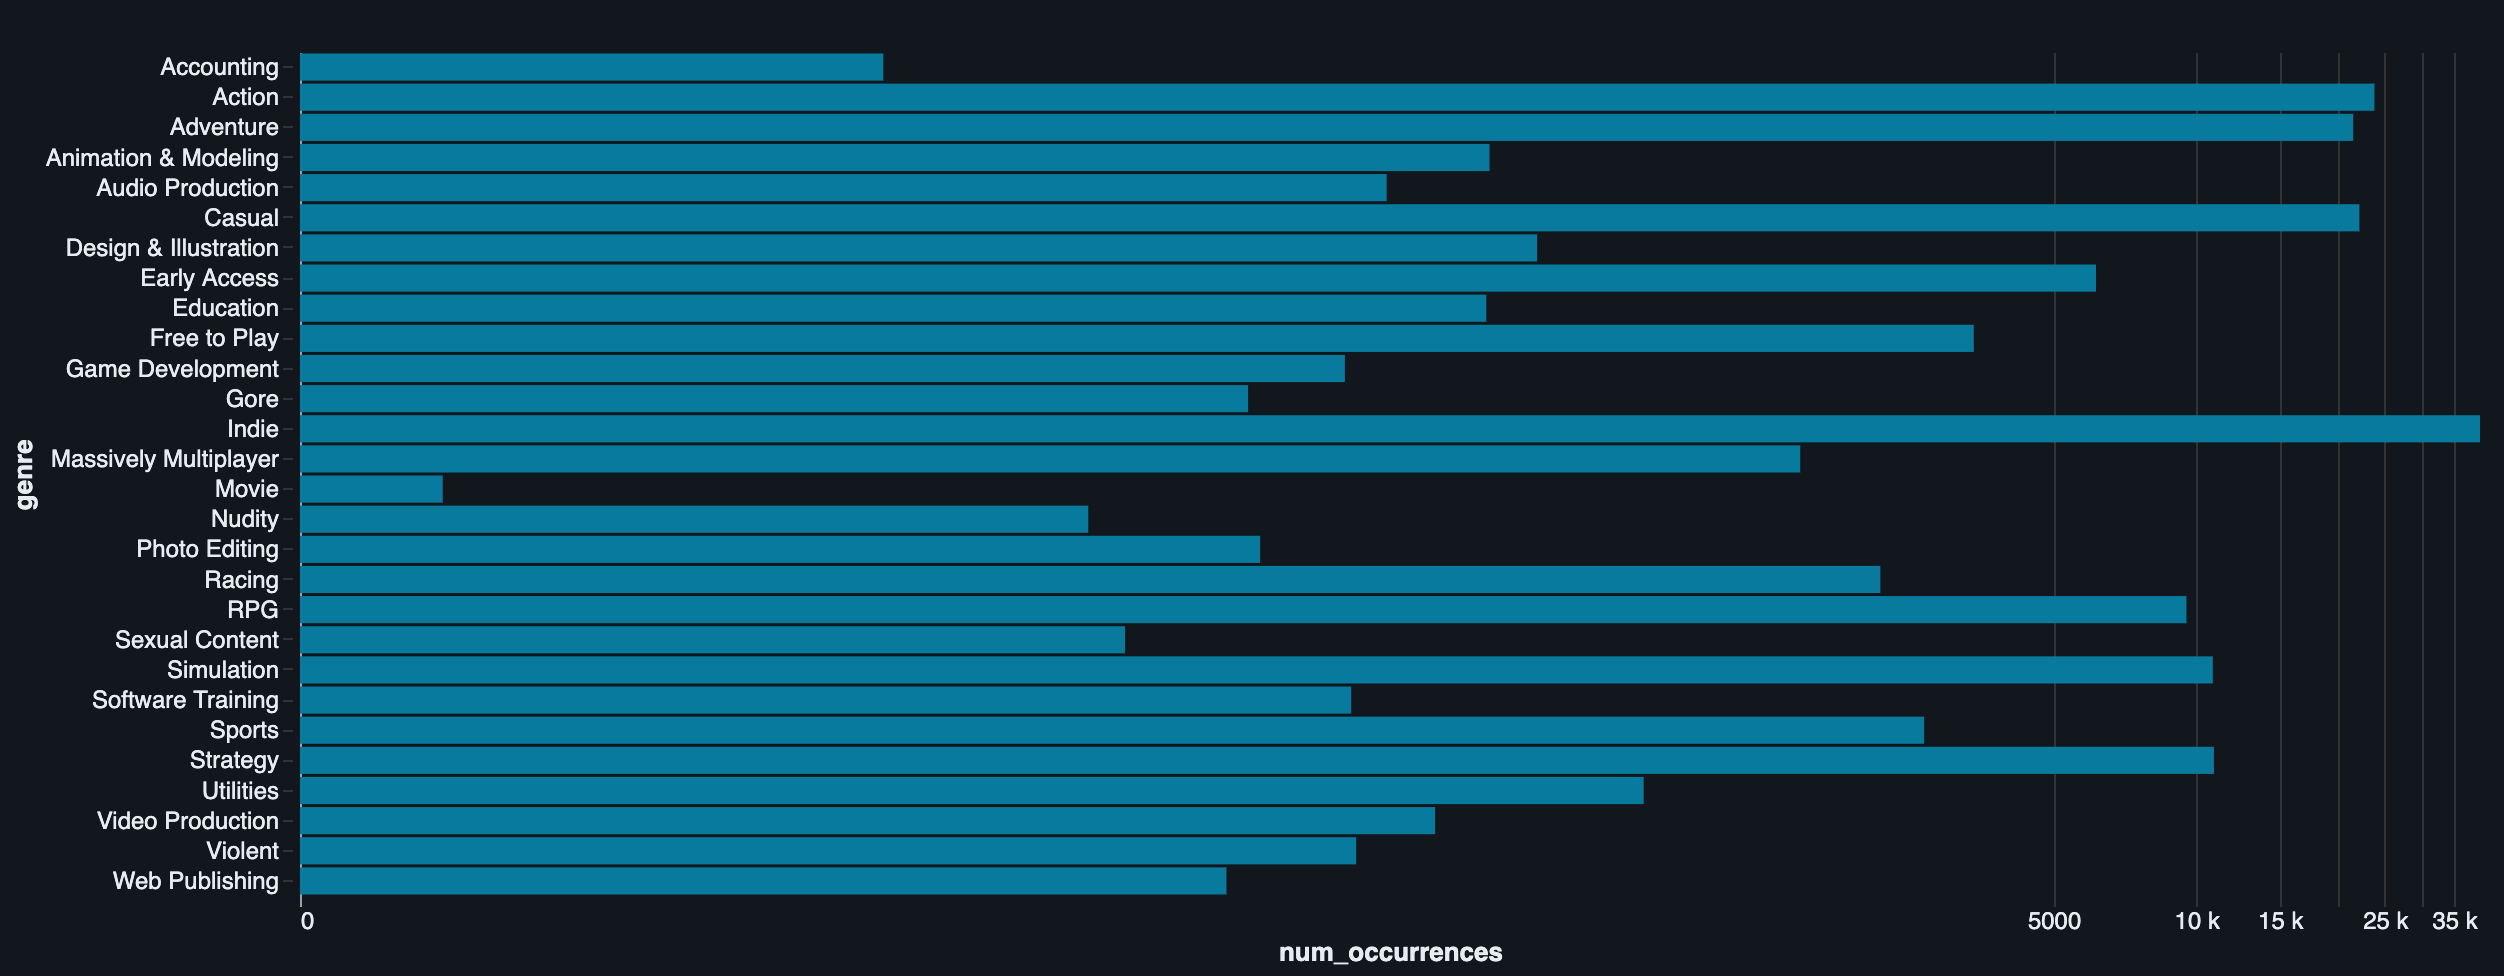

The 10 most represented genres are:
1. Indie
2. Action
3. Casual
4. Adventure
5. Strategy
6. Simulation
7. RPG
8. Early Access
9. Free to Play
10. Sports

### Are there any genres that have a better positive/negative review ratio?

In [0]:
get_genre_list = F.udf(lambda genres: [genre.strip() for genre in genres.split(",")],
                       ArrayType(StringType()))

genres_net_rating_df = df.filter(F.col("genre") != "")\
                         .withColumn("net_rating", F.col("positive_reviews") - F.col("negative_reviews"))\
                         .withColumn("genre",
                                     F.explode(
                                         get_genre_list(
                                             F.col("genre"))))\
                         .groupBy(F.col("genre"))\
                         .agg(F.sum("net_rating").alias("net_rating_sum"))\
                         .orderBy(F.desc("net_rating_sum"))
genres_net_rating_df.display()

genre,net_rating_sum
Action,45170959
Indie,28289789
Adventure,24036292
RPG,16151200
Free to Play,14441439
Simulation,13171878
Strategy,11009445
Casual,8497671
Massively Multiplayer,5040418
Early Access,3398404


Databricks visualization. Run in Databricks to view.

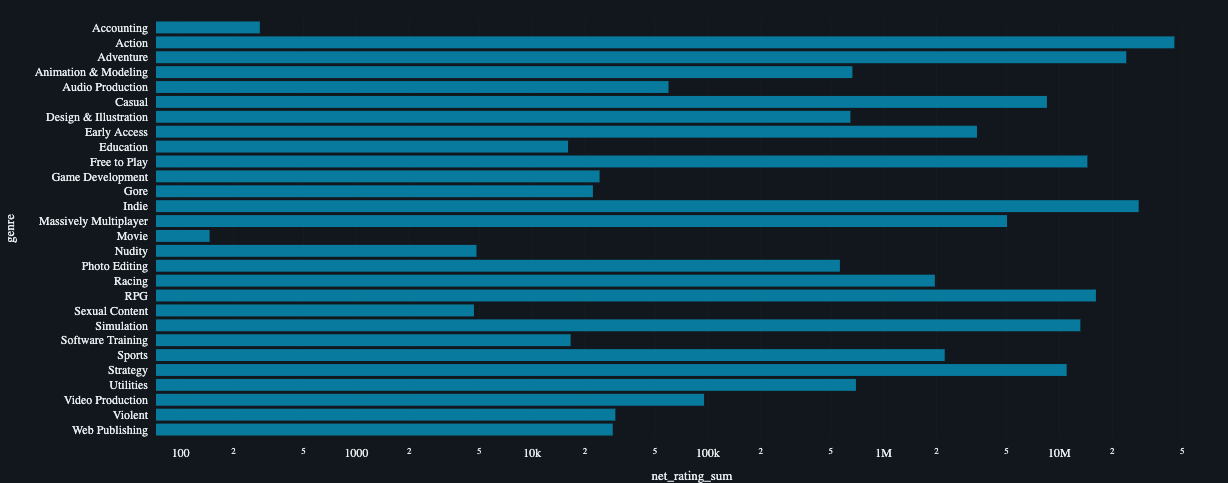

The 10 best-rated genres are:
1. Action
2. Indie
3. Adventure
4. RPG
5. Free to Play
6. Simulation
7. Strategy
8. Casual
9. Massively Multiplayer
10. Early Access

Interestingly, some genres are more popular than others despite being less frequent in the data.

### Do some publishers have favorite genres?

In [0]:
get_genre_list = F.udf(lambda genres: [genre.strip() for genre in genres.split(",")],
                       ArrayType(StringType()))

# I can't merge the two lines below because I need the first one before the "genre_occurrences" column exists
num_games_window = Window.partitionBy(F.col("publisher"))
genre_rank_window = Window.partitionBy(F.col("publisher")).orderBy(F.desc("genre_occurrences"))

fave_genres_df = df.filter((F.col("genre") != "") & ~F.col("publisher").isin(["", " "]))\
                   .withColumn("num_games_from_publisher", F.count("appid").over(num_games_window))\
                   .filter(F.col("num_games_from_publisher") >= 5)\
                   .withColumn("genre", # ↑ Publishers with very few games wouldn't give us interesting "favourite genre" values
                               F.explode(
                                   get_genre_list(
                                       F.col("genre"))))\
                   .groupBy([F.col("publisher"), F.col("genre")])\
                   .agg(F.count("genre").alias("genre_occurrences"),
                        F.max("num_games_from_publisher").alias("num_games_from_publisher"))\
                   .withColumn("genre_rank_for_publisher", F.rank().over(genre_rank_window))\
                   .filter(F.col("genre_rank_for_publisher") == 1)\
                   .withColumn("genre_size_for_publisher (%)",
                               (F.col("genre_occurrences") / F.col("num_games_from_publisher") * 100))\
                   .dropDuplicates(subset=["publisher"])\
                   .orderBy(F.desc("genre_size_for_publisher (%)"))\
                   .select([F.col("publisher"),
                            F.col("genre"),
                            F.col("genre_size_for_publisher (%)"),
                            F.col("num_games_from_publisher")])
get_head_as_df(fave_genres_df)

publisher,genre,genre_size_for_publisher (%),num_games_from_publisher
Afterthought Studios,Simulation,100.0,8
Andy Jurko,Indie,100.0,17
Age of Fear,Indie,100.0,5
0Cube,Adventure,100.0,19
Ahlman Game Studio,Free to Play,100.0,11
7DOTS,Indie,100.0,6
Airem,Indie,100.0,7
8floor,Casual,100.0,202
90E GAMES,Action,100.0,7
AFBIK Studio,Casual,100.0,20


This doesn't tell us very much, let's look at the distribution of favourite genre sizes for each publisher.\
I initially tried undoing the percentage in the "genre_size_for_publisher" column in order to account for the fact that it's easier to have a bigger percentage when you don't have a lot of games, but it actually makes the gap much wider and the visualisation much harder to interpret.

In [0]:
fave_genres_df.select(F.col("genre_size_for_publisher (%)"))\
              .display()

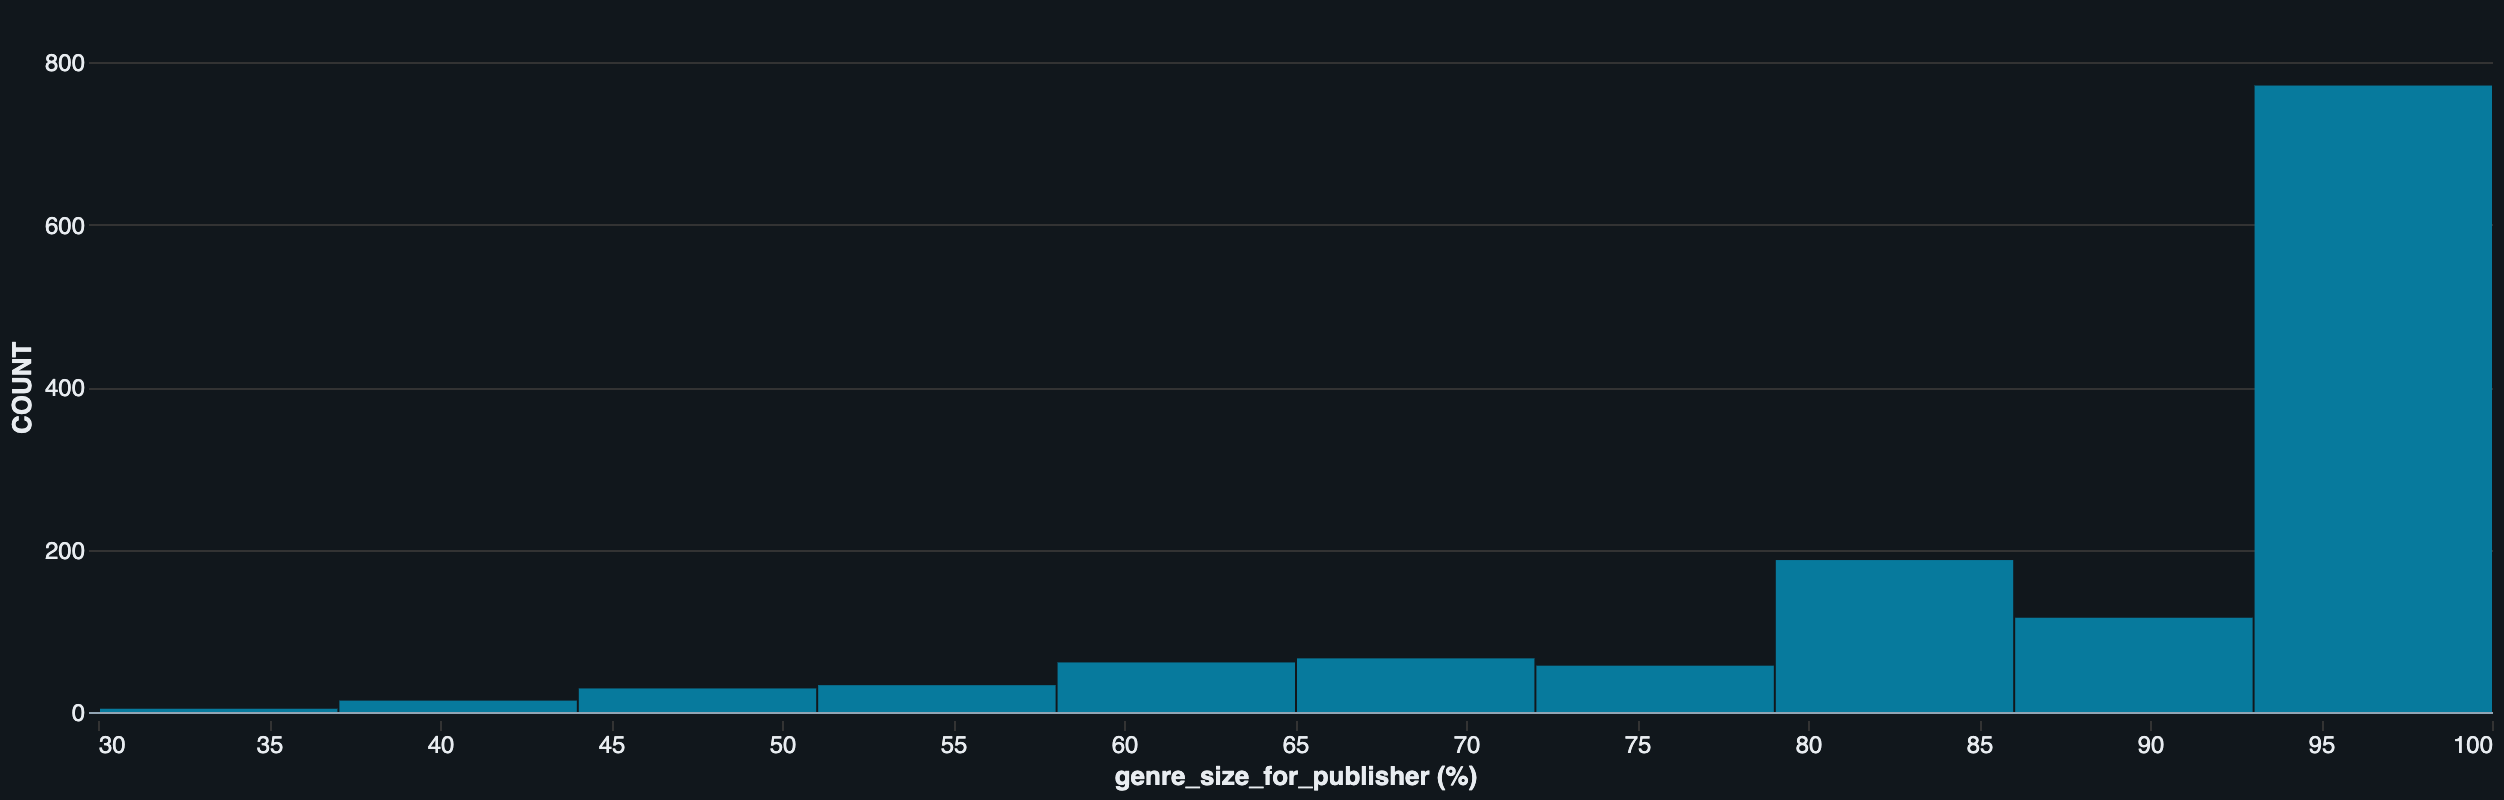

It seems that the majority of publishers mostly stick to a single genre. This may not work, but let's try treating each combination of categories as one category and seeing if the results are any different:

In [0]:
get_genres_concat = F.udf(lambda genres: "".join(
                                                sorted(
                                                    [genre.strip().lower() for genre in genres.split(",")])),
                          StringType())

# I can't merge the two lines below because I need the first one before the "genre_occurrences" column exists
num_games_window = Window.partitionBy(F.col("publisher"))
genre_rank_window = Window.partitionBy(F.col("publisher")).orderBy(F.desc("genre_occurrences"))

fave_genres_df_2 = df.filter((F.col("genre") != "") & ~F.col("publisher").isin(["", " "]))\
                   .withColumn("num_games_from_publisher", F.count("appid").over(num_games_window))\
                   .filter(F.col("num_games_from_publisher") >= 5)\
                   .withColumn("genre", # ↑ Publishers with very few games wouldn't give us interesting "favourite genre" values
                               get_genres_concat(
                                   F.col("genre")))\
                   .groupBy([F.col("publisher"), F.col("genre")])\
                   .agg(F.count("genre").alias("genre_occurrences"),
                        F.max("num_games_from_publisher").alias("num_games_from_publisher"))\
                   .withColumn("genre_rank_for_publisher", F.rank().over(genre_rank_window))\
                   .filter(F.col("genre_rank_for_publisher") == 1)\
                   .withColumn("genre_size_for_publisher (%)",
                               (F.col("genre_occurrences") / F.col("num_games_from_publisher") * 100))\
                   .dropDuplicates(subset=["publisher"])\
                   .orderBy(F.desc("genre_size_for_publisher (%)"))\
                   .select([F.col("publisher"),
                            F.col("genre"),
                            F.col("genre_size_for_publisher (%)"),
                            F.col("num_games_from_publisher")])
fave_genres_df_2.display()

publisher,genre,genre_size_for_publisher (%),num_games_from_publisher
Adamvision Studios,actioncasualindie,100.0,9
Attack Studio,casual,100.0,6
Cherry Kiss Games,casual,100.0,6
ChessBase GmbH,strategy,100.0,8
DIG Publishing,casualindie,100.0,10
Do Games Limited,adventurecasual,100.0,6
DominiGames,adventurecasual,100.0,13
Dovetail Games - Trains,simulation,100.0,5
"Epic Games, Inc.",action,100.0,5
GirlGames,casualindierpgsimulation,100.0,7


Databricks visualization. Run in Databricks to view.

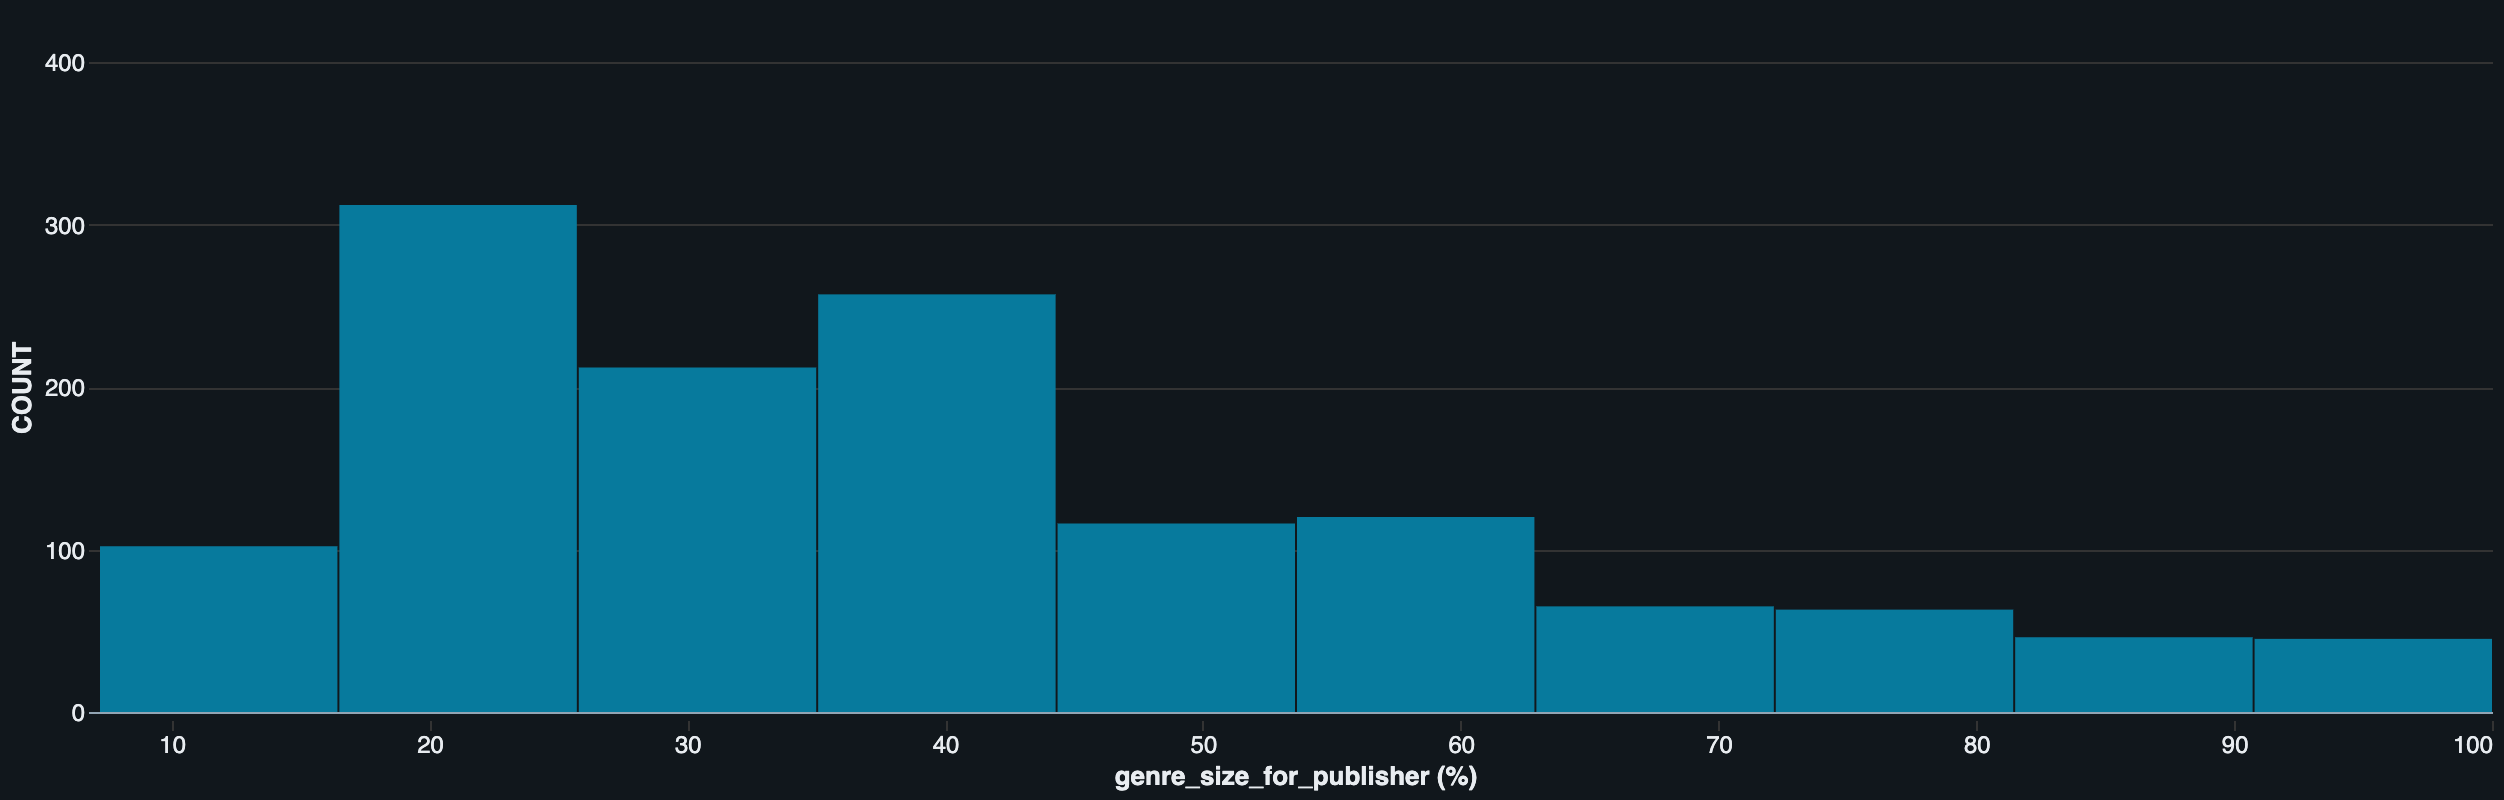

For the most part, it seems like publishers do have a little variety in the genre combinations of the games they publish on Steam.

In [0]:
get_head_as_df(fave_genres_df_2.select(F.col("genre"))\
                               .groupBy(F.col("genre"))\
                               .agg(F.count("genre"))\
                               .sort(F.desc("count(genre)")))

genre,count(genre)
casualindie,113
actionindie,97
actionadventureindie,79
adventureindie,64
action,61
casual,60
adventurecasualindie,58
indie,49
actioncasualindie,45
adventure,42


Databricks visualization. Run in Databricks to view.

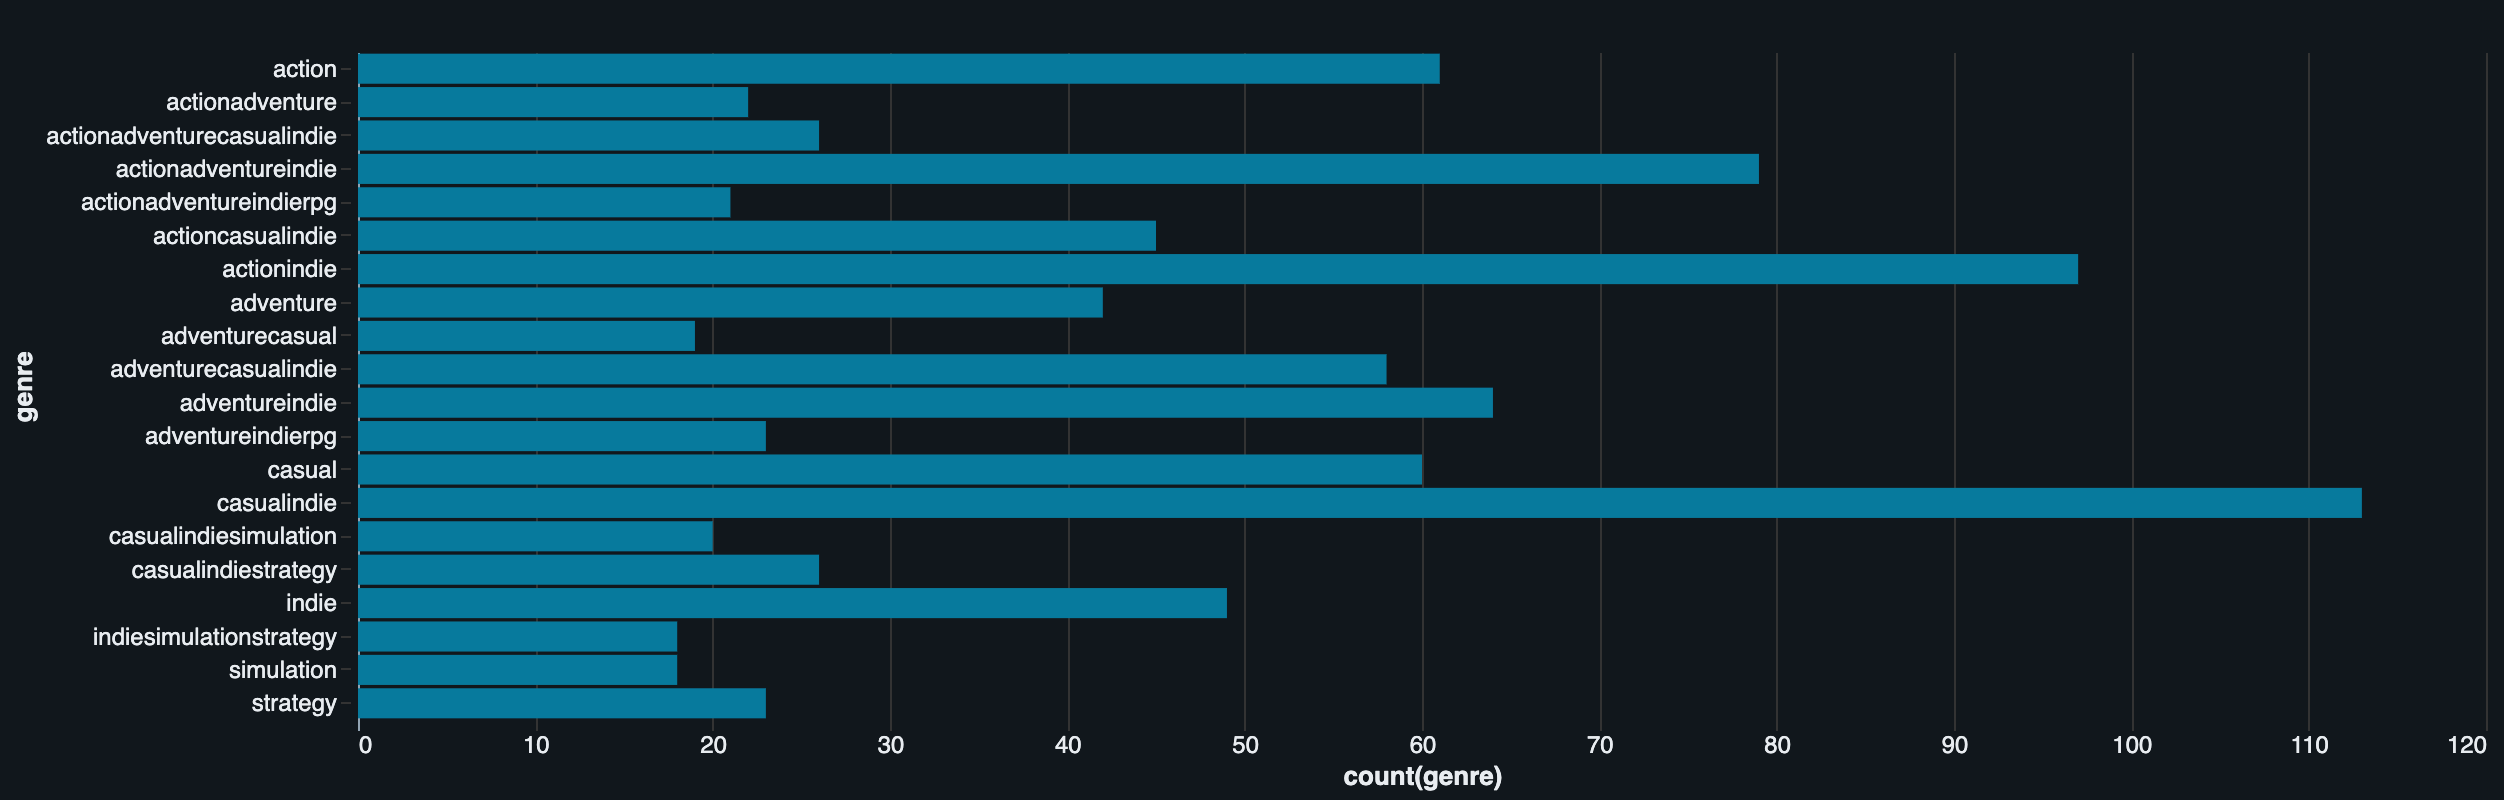

### What are the most lucrative genres?

Because doing otherwise would be complex and way beyond the scope of the project, I will assume that each genre assigned to a game contributes equally and fully (i.e. no need to divide a retail price associated with a genre by the number of genres assigned to a game) to its retail price, and that the fact that genres are combined in different ways throughout the data will naturally bring the more important genres to the top (i.e. if a cheap game has the genres "action, puzzle, rpg" and an expensive game has the genres "action, puzzle, indie", I will assume that "indie" is more lucrative than "rpg" even though there could be other factors at play).

In [0]:
get_genre_list = F.udf(lambda genres: [genre.strip() for genre in genres.split(",")],
                       ArrayType(StringType()))

lucrative_genre_df = df.withColumn("genre",
                                   F.explode(
                                       get_genre_list(
                                           F.col("genre"))))\
                       .groupBy(F.col("genre"))\
                       .agg(F.sum("price").alias("price_for_genre"))\
                       .orderBy(F.desc("price_for_genre"))
get_head_as_df(lucrative_genre_df)

genre,price_for_genre
Indie,2.6063036E7
Action,1.8358769E7
Adventure,1.7158179E7
Casual,1.2383583E7
Simulation,9851654.0
Strategy,9157201.0
RPG,8621295.0
Early Access,5375795.0
Sports,2385529.0
Racing,1771645.0


Databricks visualization. Run in Databricks to view.

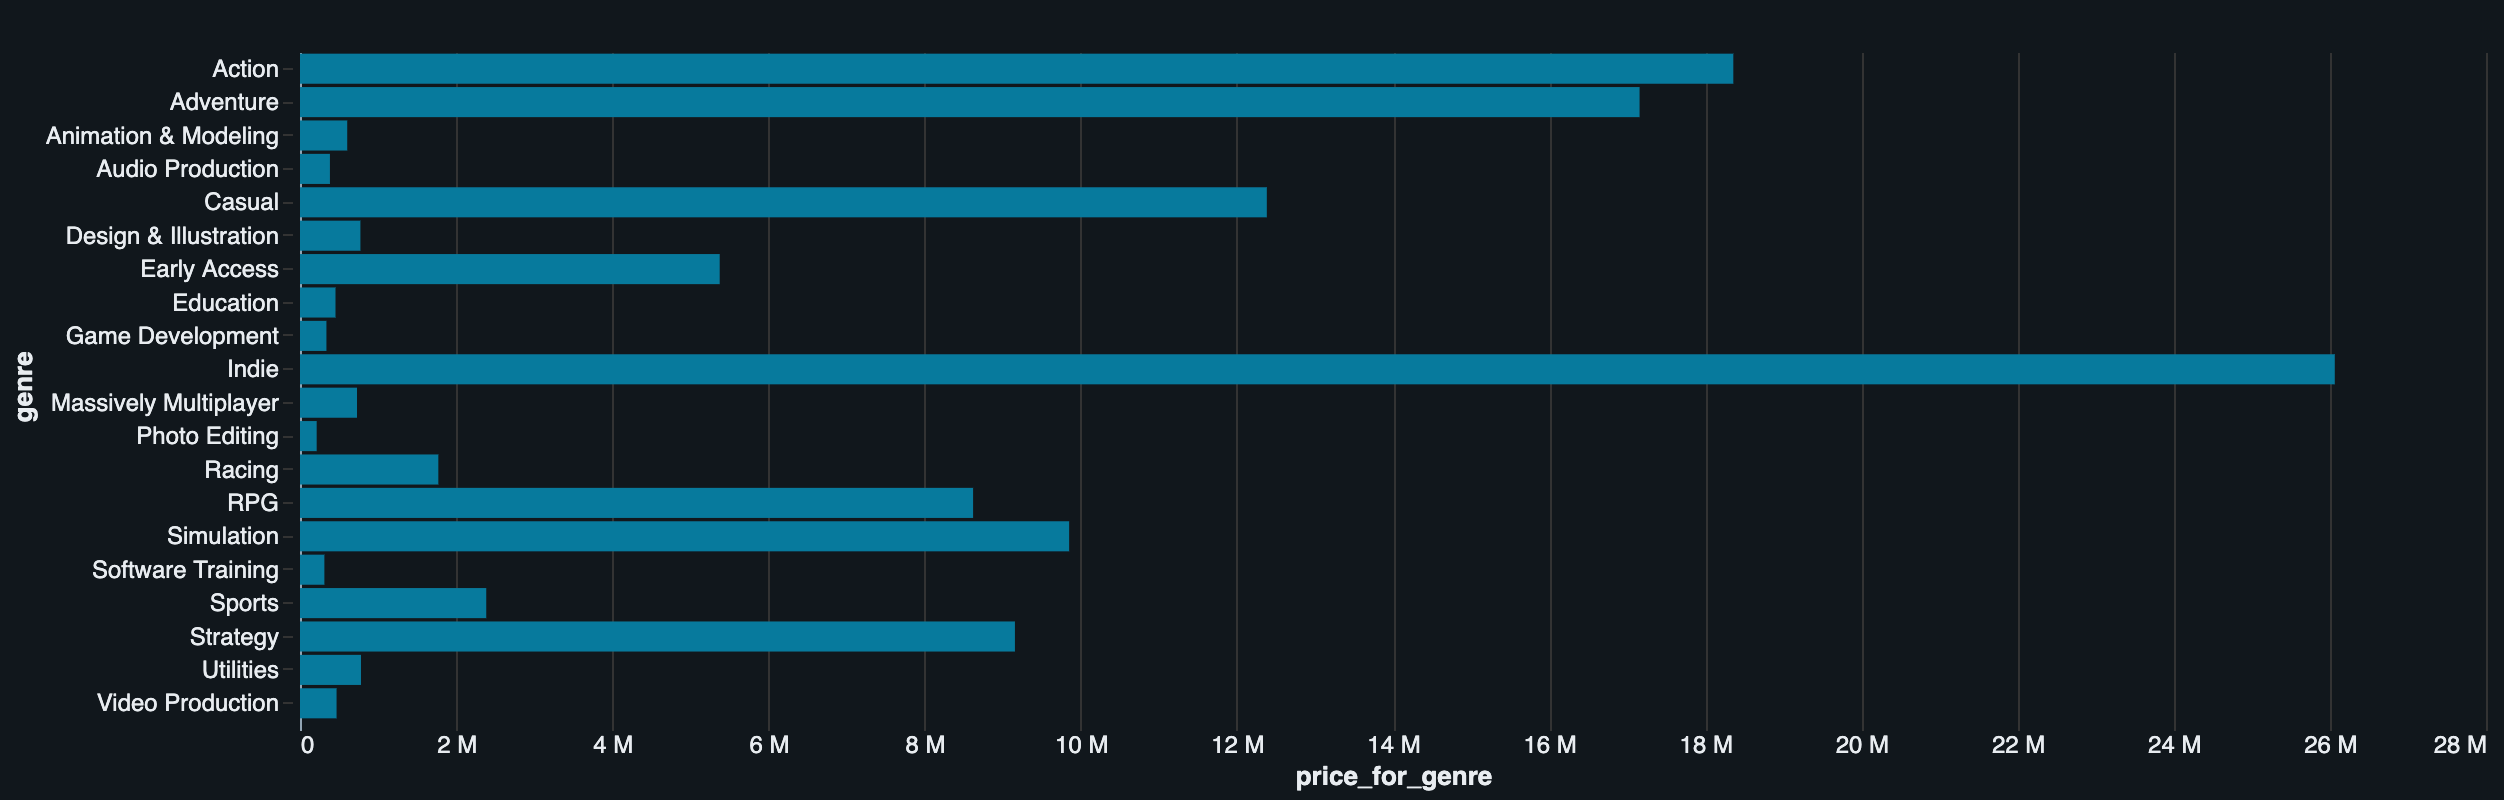

Each value in "price_for_genre" corresponds to the sum of the retail prices of all games that are shown as belonging to a given genre, and not how much money this specific genre brought to publishers. However, because there are many samples with different combinations of genres, I believe that it works out to something approaching the latter in terms of the relative sizes of the values.

## Platform analysis

### Are most games available on Windows/Mac/Linux?

In [0]:
get_platf_list = F.udf(lambda platforms: [platform.strip() for platform in platforms.split(",")],
                       ArrayType(StringType()))

platforms_df = df.withColumn("platforms",
                             F.explode(
                                 get_platf_list(
                                     F.col("platforms"))))\
                 .groupBy(F.col("platforms"))\
                 .agg(F.count("appid").alias("compatible_game_count"))\
                 .orderBy(F.desc("compatible_game_count"))

platforms_df.display()

platforms,compatible_game_count
windows,41271
linux,8457
mac,5962


Databricks visualization. Run in Databricks to view.

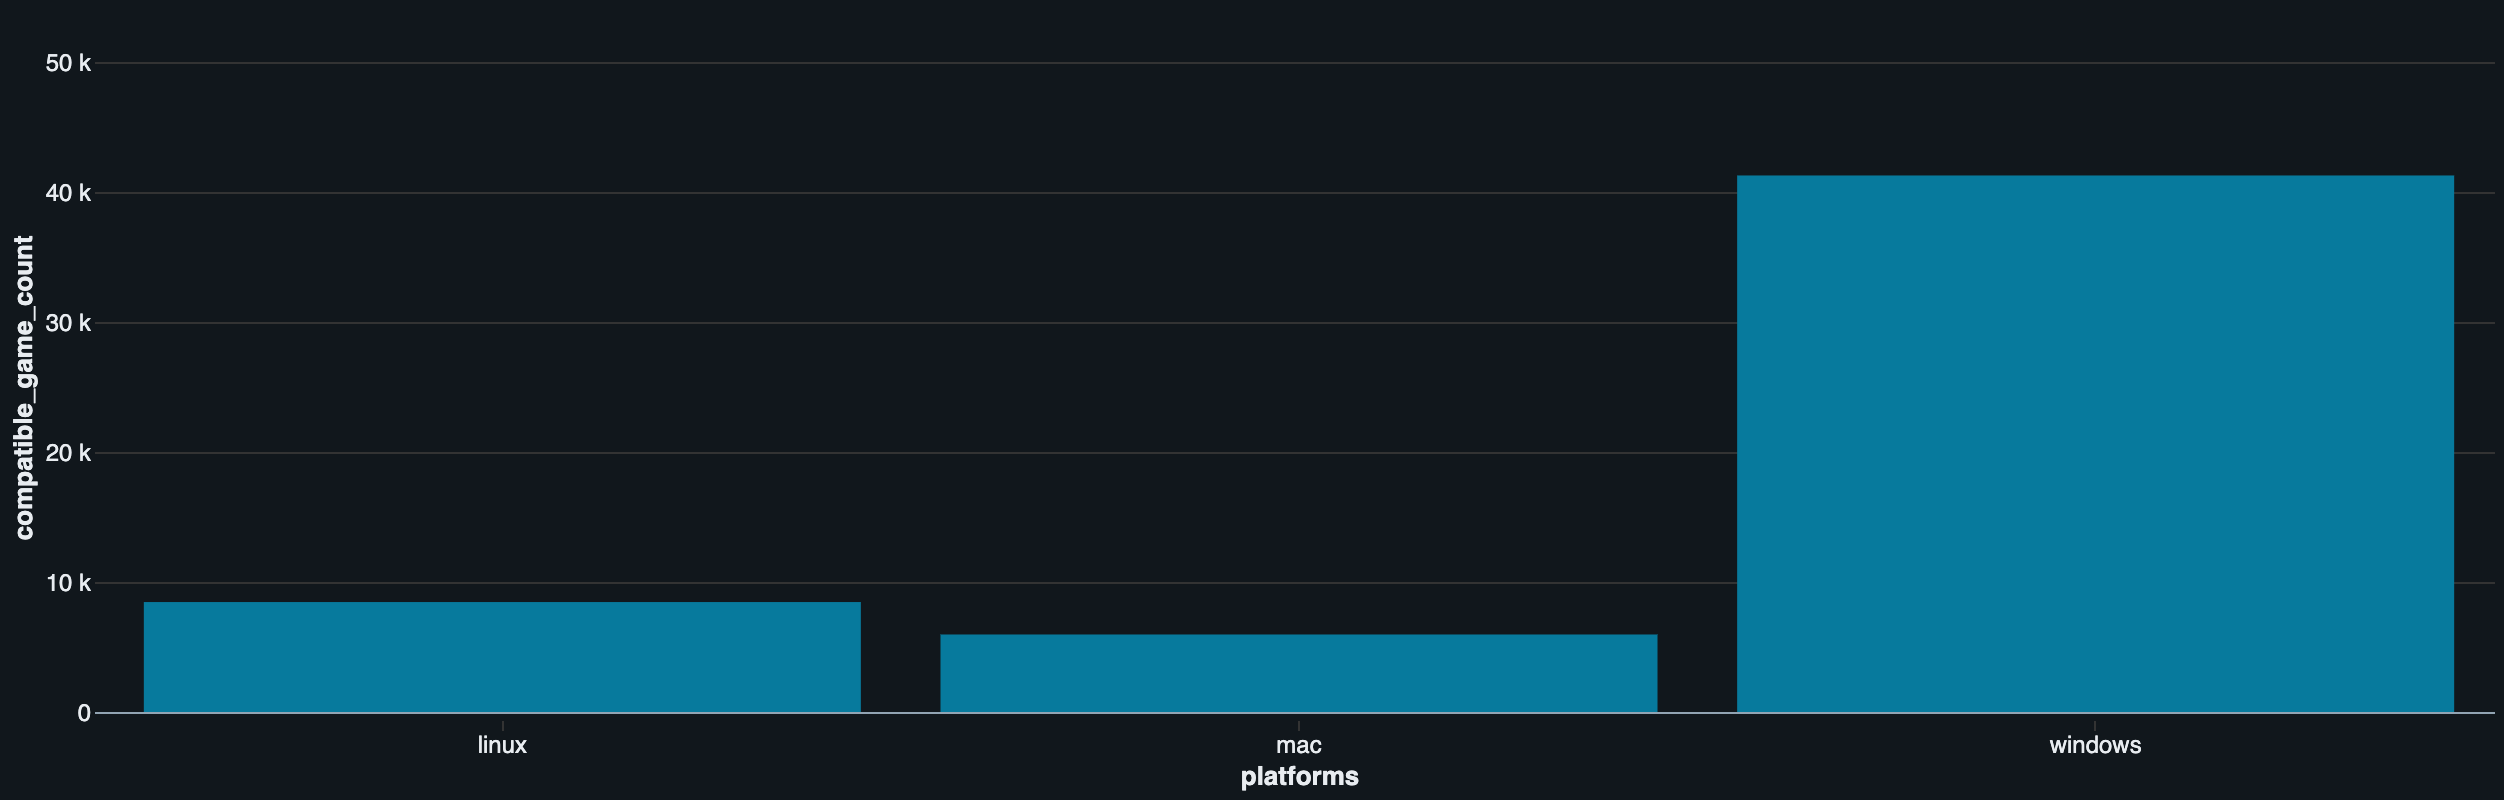

### Do certain genres tend to be preferentially available on certain platforms?

In [0]:
get_elem_list = F.udf(lambda elems: [elem.strip() for elem in elems.split(",")],
                      ArrayType(StringType()))

def row_std(*cols):
    row_vals = [*cols]
    mean = sum(row_vals) / len(row_vals)
    variance = sum([(val - mean) ** 2 for val in row_vals])\
               / len(row_vals)
    return variance ** 0.5

row_std = F.udf(row_std, DoubleType())

genres_platforms_df = df.filter(F.col("genre") != "")\
                        .withColumn("platforms",
                                    F.explode(
                                        get_elem_list(
                                            F.col("platforms"))))\
                        .withColumn("genre",
                                    F.explode(
                                        get_elem_list(
                                            F.col("genre"))))\
                        .groupBy(F.col("genre"))\
                        .agg(F.count(
                                F.when((F.col("platforms") == "mac"), True)
                                ).alias("mac_compatible_games"),
                             F.count(
                                F.when((F.col("platforms") == "windows"), True)
                                ).alias("windows_compatible_games"),
                             F.count(
                                F.when((F.col("platforms") == "linux"), True)
                                ).alias("linux_compatible_games"),
                             F.countDistinct(
                                F.col("appid")
                                ).alias("num_games_for_genre"))\
                        .withColumn("share_mac_compatible_games (%)",
                                    F.col("mac_compatible_games") / F.col("num_games_for_genre") * 100)\
                        .withColumn("share_windows_compatible_games (%)",
                                    F.col("windows_compatible_games") / F.col("num_games_for_genre") * 100)\
                        .withColumn("share_linux_compatible_games (%)",
                                    F.col("linux_compatible_games") / F.col("num_games_for_genre") * 100)\
                        .withColumn("platf_share_std", row_std(F.col("share_mac_compatible_games (%)"),
                                                               F.col("share_windows_compatible_games (%)"),
                                                               F.col("share_linux_compatible_games (%)")))\
                        .orderBy(F.desc("platf_share_std"))\
                        .select(["genre",
                                 "share_mac_compatible_games (%)",
                                 "share_windows_compatible_games (%)",
                                 "share_linux_compatible_games (%)"])\

genres_platforms_df.display()

genre,share_mac_compatible_games (%),share_windows_compatible_games (%),share_linux_compatible_games (%)
Movie,0.0,100.0,0.0
Video Production,9.7165991902834,87.85425101214574,2.42914979757085
Photo Editing,11.428571428571429,84.76190476190476,3.8095238095238098
Utilities,8.944281524926687,83.87096774193549,7.184750733137831
Early Access,7.469487388120423,82.24572823433685,10.284784377542717
Software Training,10.975609756097562,81.70731707317073,7.317073170731707
Education,12.618296529968454,81.38801261829653,5.993690851735016
Violent,6.547619047619048,80.35714285714286,13.095238095238097
Gore,6.0606060606060606,79.7979797979798,14.14141414141414
Massively Multiplayer,9.315068493150685,79.45205479452055,11.232876712328768


Databricks visualization. Run in Databricks to view.

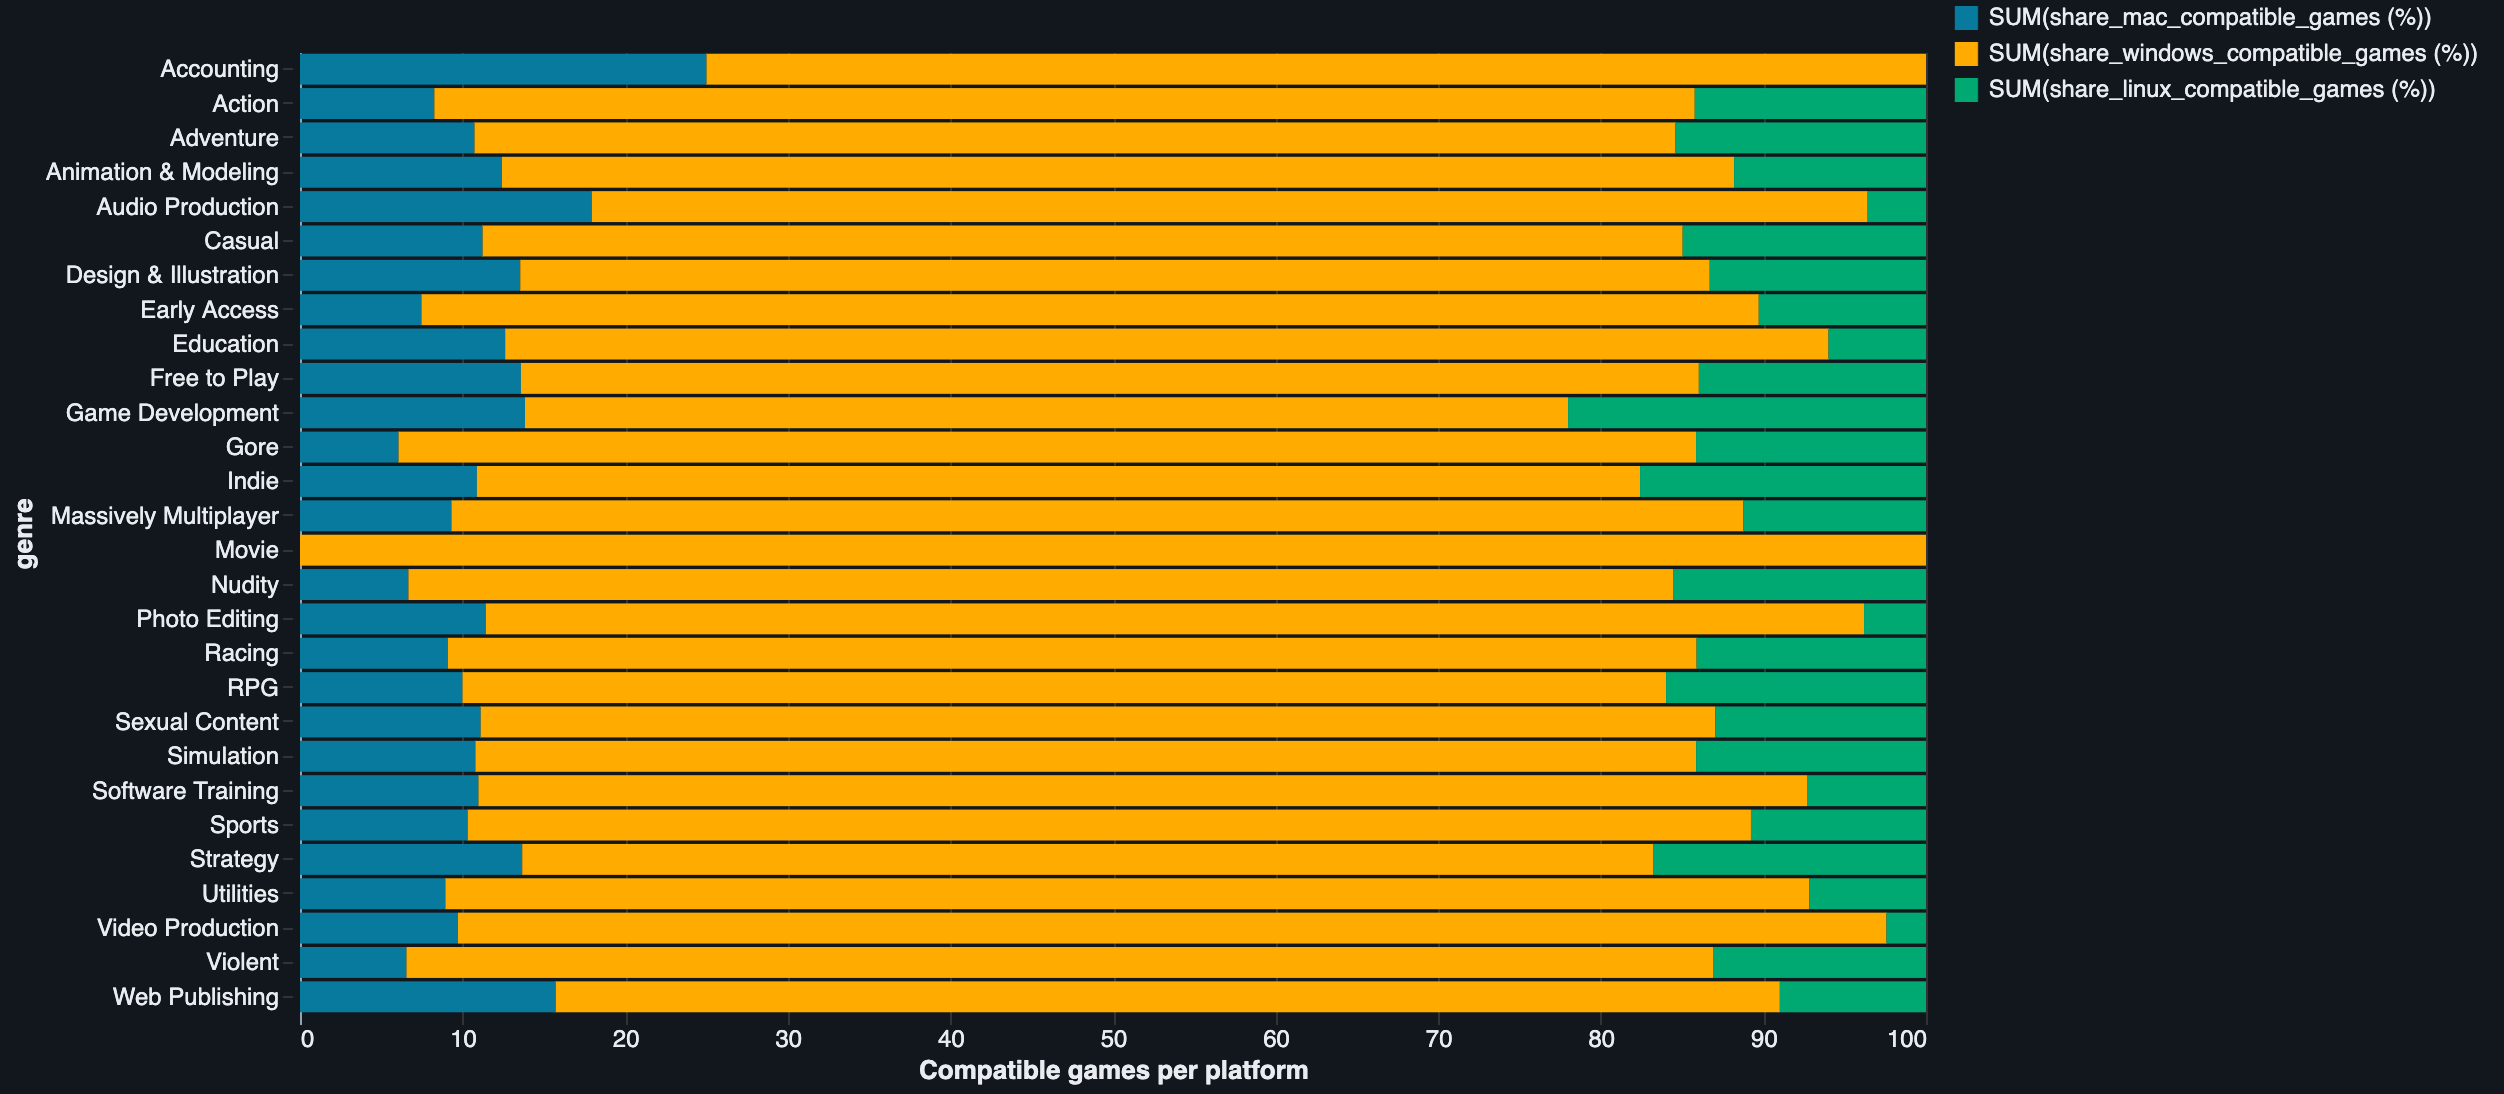

In [0]:
genre_rank_window = Window.partitionBy(F.col("platforms")).orderBy(F.desc("genre_occurrences_for_platform"))

top_genre_for_platform_df = df.filter(F.col("genre") != "")\
                              .withColumn("platforms",
                                          F.explode(
                                              get_elem_list(
                                                  F.col("platforms"))))\
                              .withColumn("genre",
                                          F.explode(
                                              get_elem_list(
                                                  F.col("genre"))))\
                              .groupBy(F.col("platforms"), F.col("genre"))\
                              .agg(F.count("genre").alias("genre_occurrences_for_platform"))\
                              .withColumn("genre_rank_for_platform", F.rank().over(genre_rank_window))\
                              .filter(F.col("genre_rank_for_platform") == 1)\
                              .select(["platforms", "genre"])\
                              .withColumnRenamed("genre", "top_genre")
top_genre_for_platform_df.display()

platforms,top_genre
linux,Indie
mac,Indie
windows,Indie
